# Análisis y tratamiento de valores faltantes en dataset del titánic

Este notebook analiza el tratamiento de valores faltantes en el dataset del Titanic, implementando diferentes estrategias de imputación y validación

**Contenido**:
1. Análisis detallado de Missingness

2. Estrategias de imputación

3. Validación de imputaciones

## Importar librerías


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import missingno as msno

In [83]:
# Configuraciones de visualización
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
df = pd.read_csv('../data/Titanic-Dataset-Canvas.csv')

# Mostrar información inicial
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
print(df.info())

Dimensiones del dataset: (891, 12)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## 1. Análisis Detallado de Missingness


### 1.1 Patrón de Missingness
Analizaremos si los valores faltantes siguen un patrón MCAR (Missing Completely at Random), MAR (Missing at Random) o MNAR (Missing Not at Random).

In [84]:
# Análisis de valores faltantes
print("1. Análisis de Valores Faltantes:")
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percentages
}).sort_values('Porcentaje', ascending=False)

print(missing_info[missing_info['Valores Faltantes'] > 0])

1. Análisis de Valores Faltantes:
          Valores Faltantes  Porcentaje
Cabin                   687   77.104377
Age                     177   19.865320
Embarked                  2    0.224467


### 1.1.2 Visualización de Patrones de Valores Faltantes
Utilizamos la librería `missingno` para visualizar los patrones de datos faltantes y detectar posibles correlaciones entre las ausencias.

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\111619552.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x600 with 0 Axes>

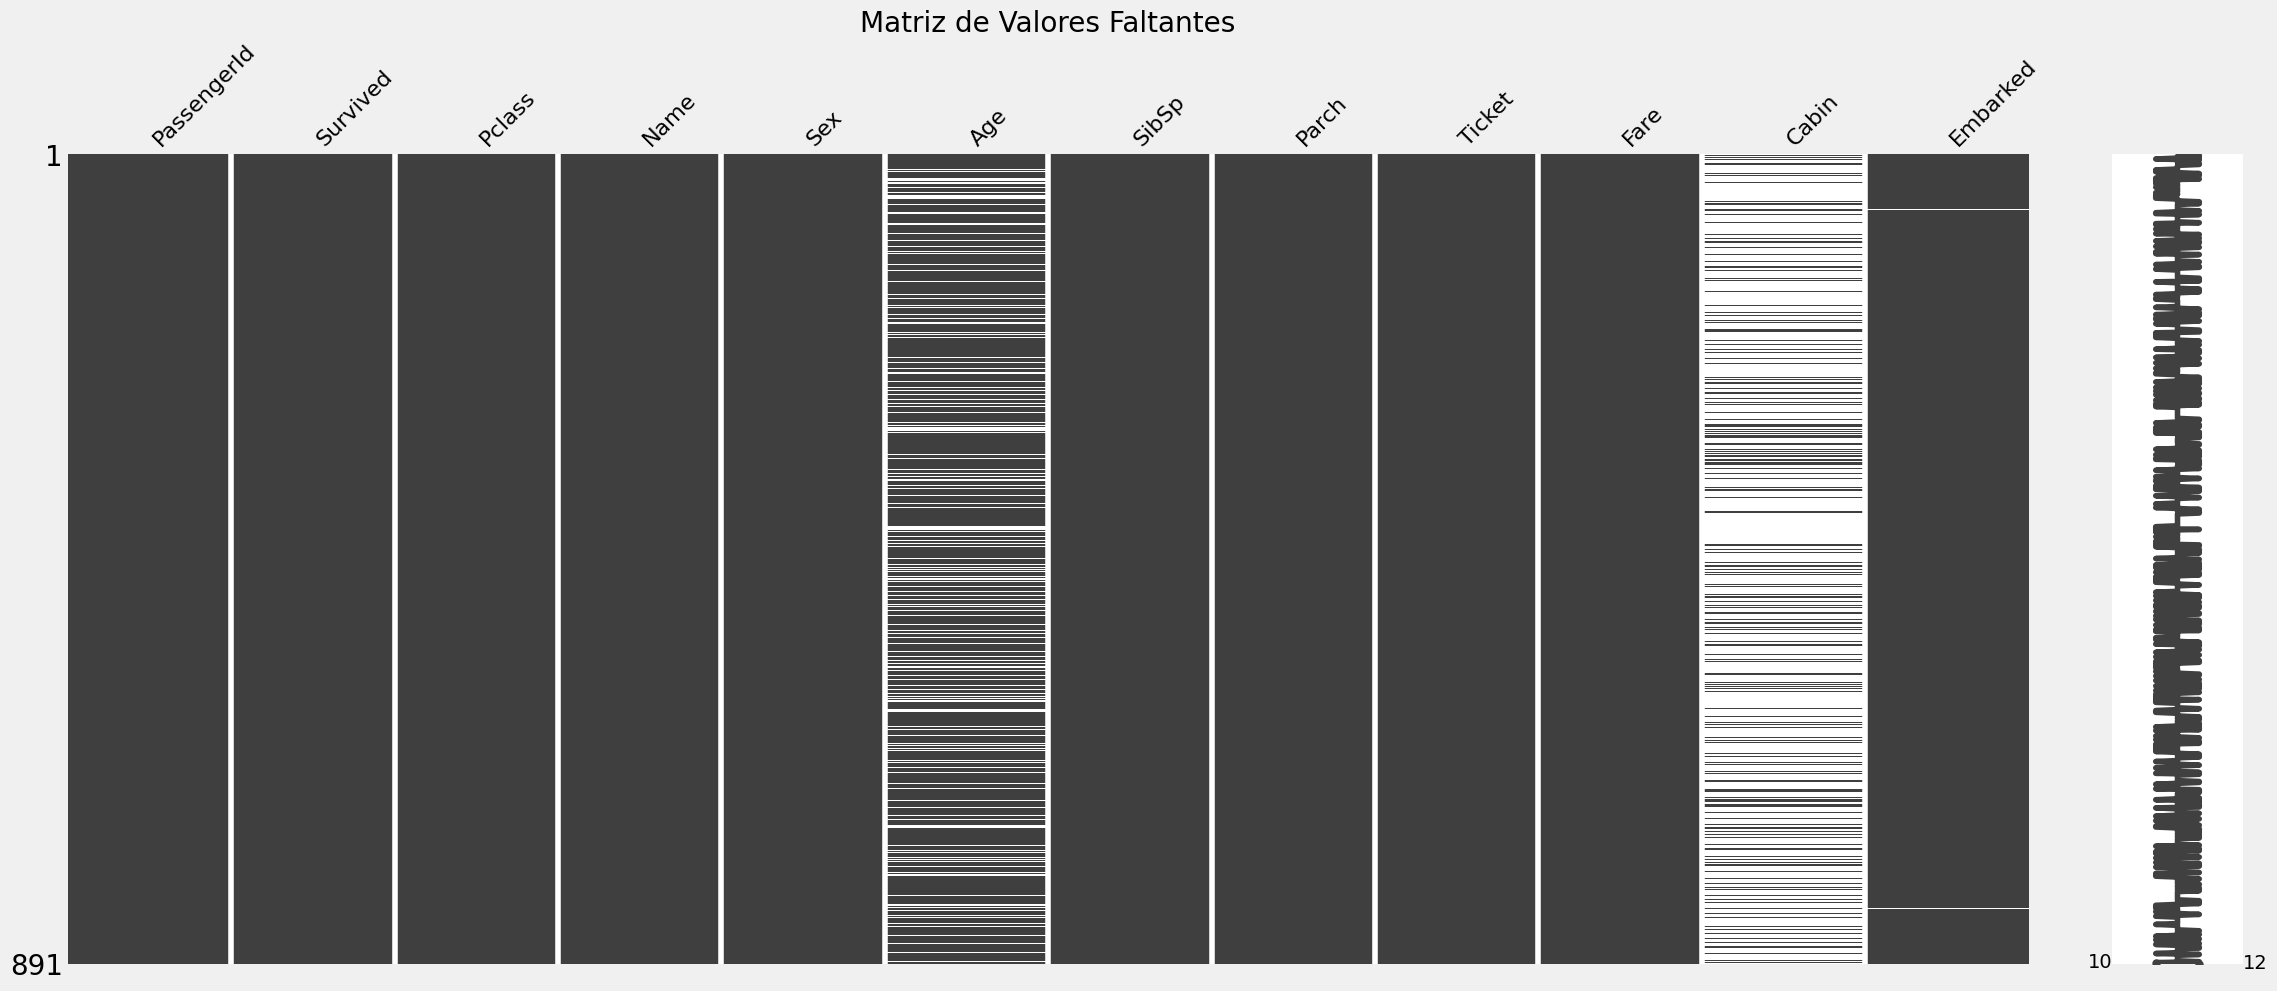

In [85]:
# Visualización de patrones de valores faltantes
plt.figure(figsize=(15, 6))
msno.matrix(df)
plt.title('Matriz de Valores Faltantes')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

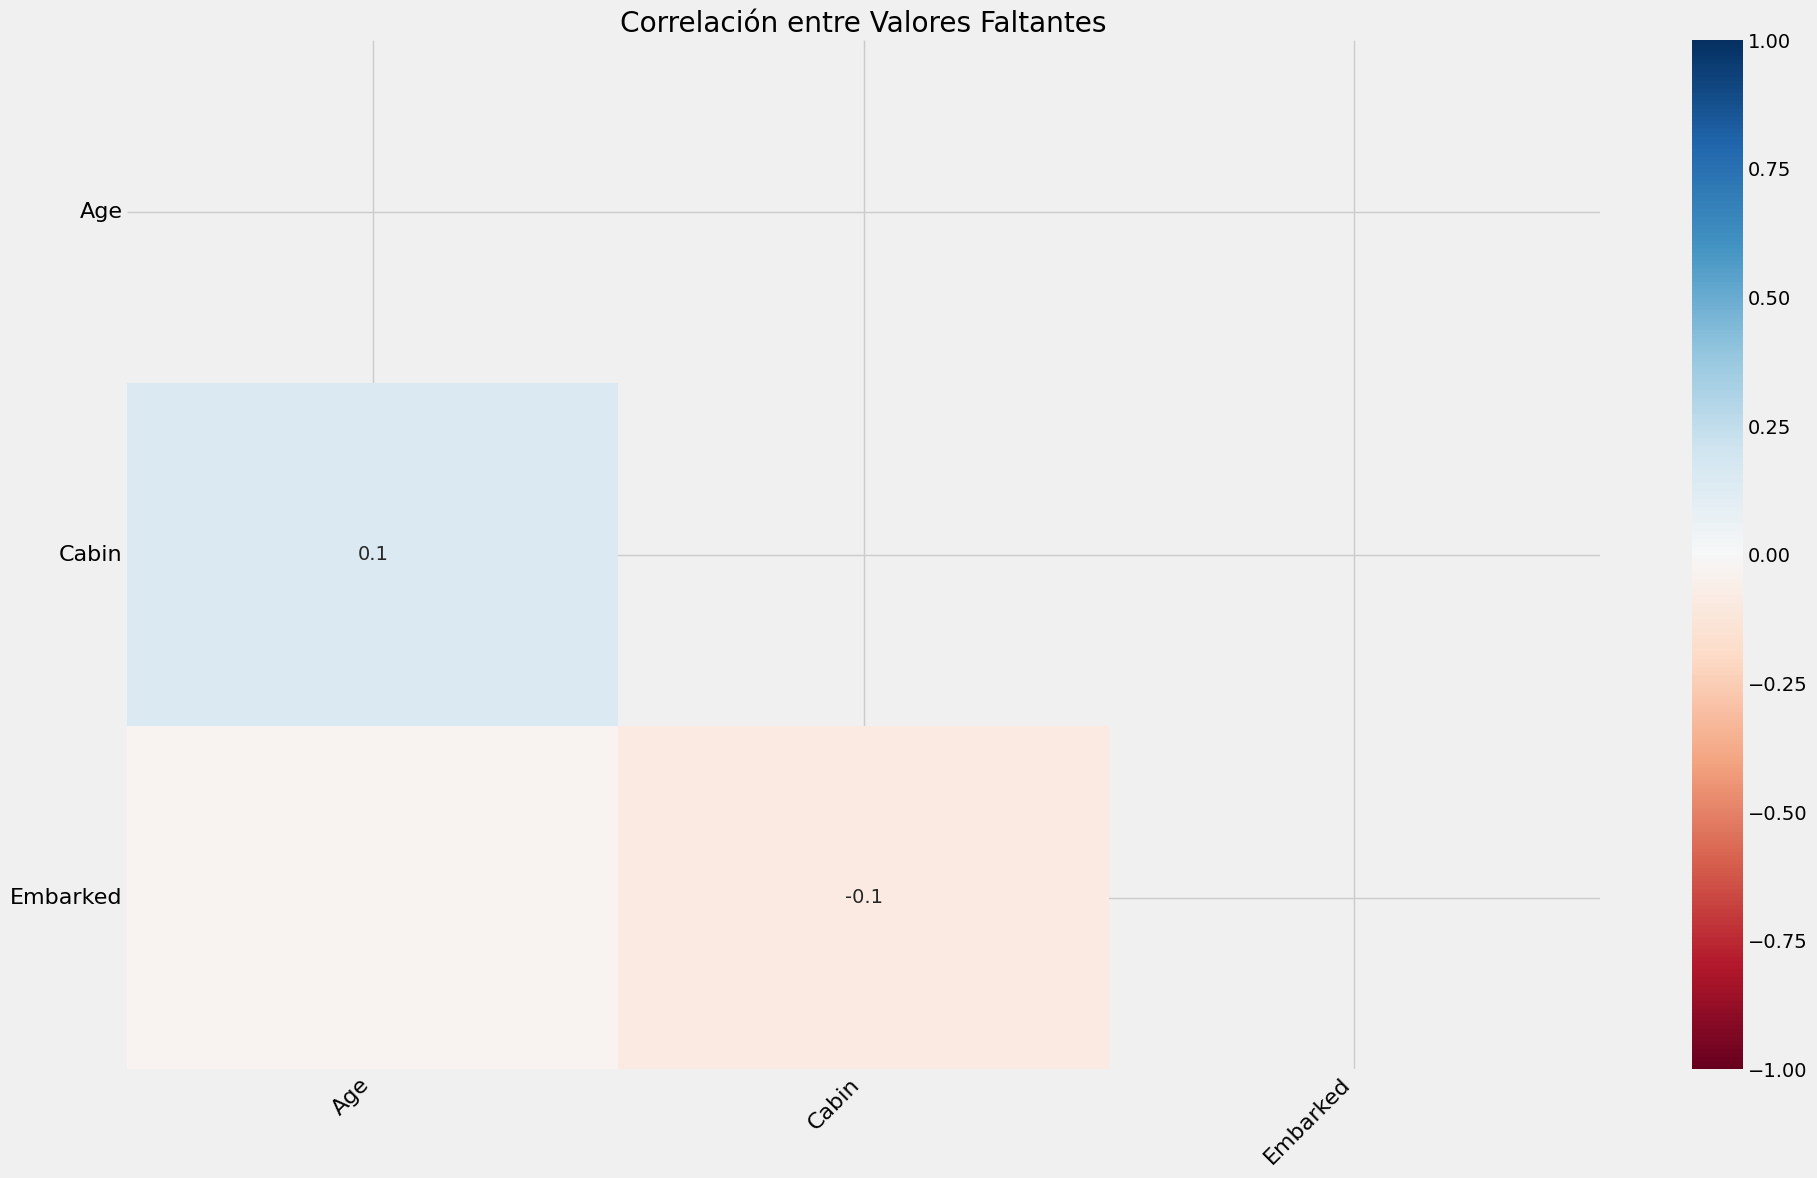

In [86]:
# Heatmap de correlación entre valores faltantes
plt.figure(figsize=(12, 8))
msno.heatmap(df)
plt.title('Correlación entre Valores Faltantes')
plt.tight_layout()
plt.show()

### 1.1.3 Análisis de Variables Numéricas
Examinamos las estadísticas descriptivas y distribuciones de las variables numéricas para entender mejor los datos.

In [87]:
# Análisis de variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("2. Estadísticas de Variables Numéricas:")
print(df[numeric_cols].describe())

2. Estadísticas de Variables Numéricas:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


### 1.1.4 Distribuciones de Variables Numéricas
Visualizamos la distribución de cada variable numérica para identificar patrones, sesgos y posibles outliers.

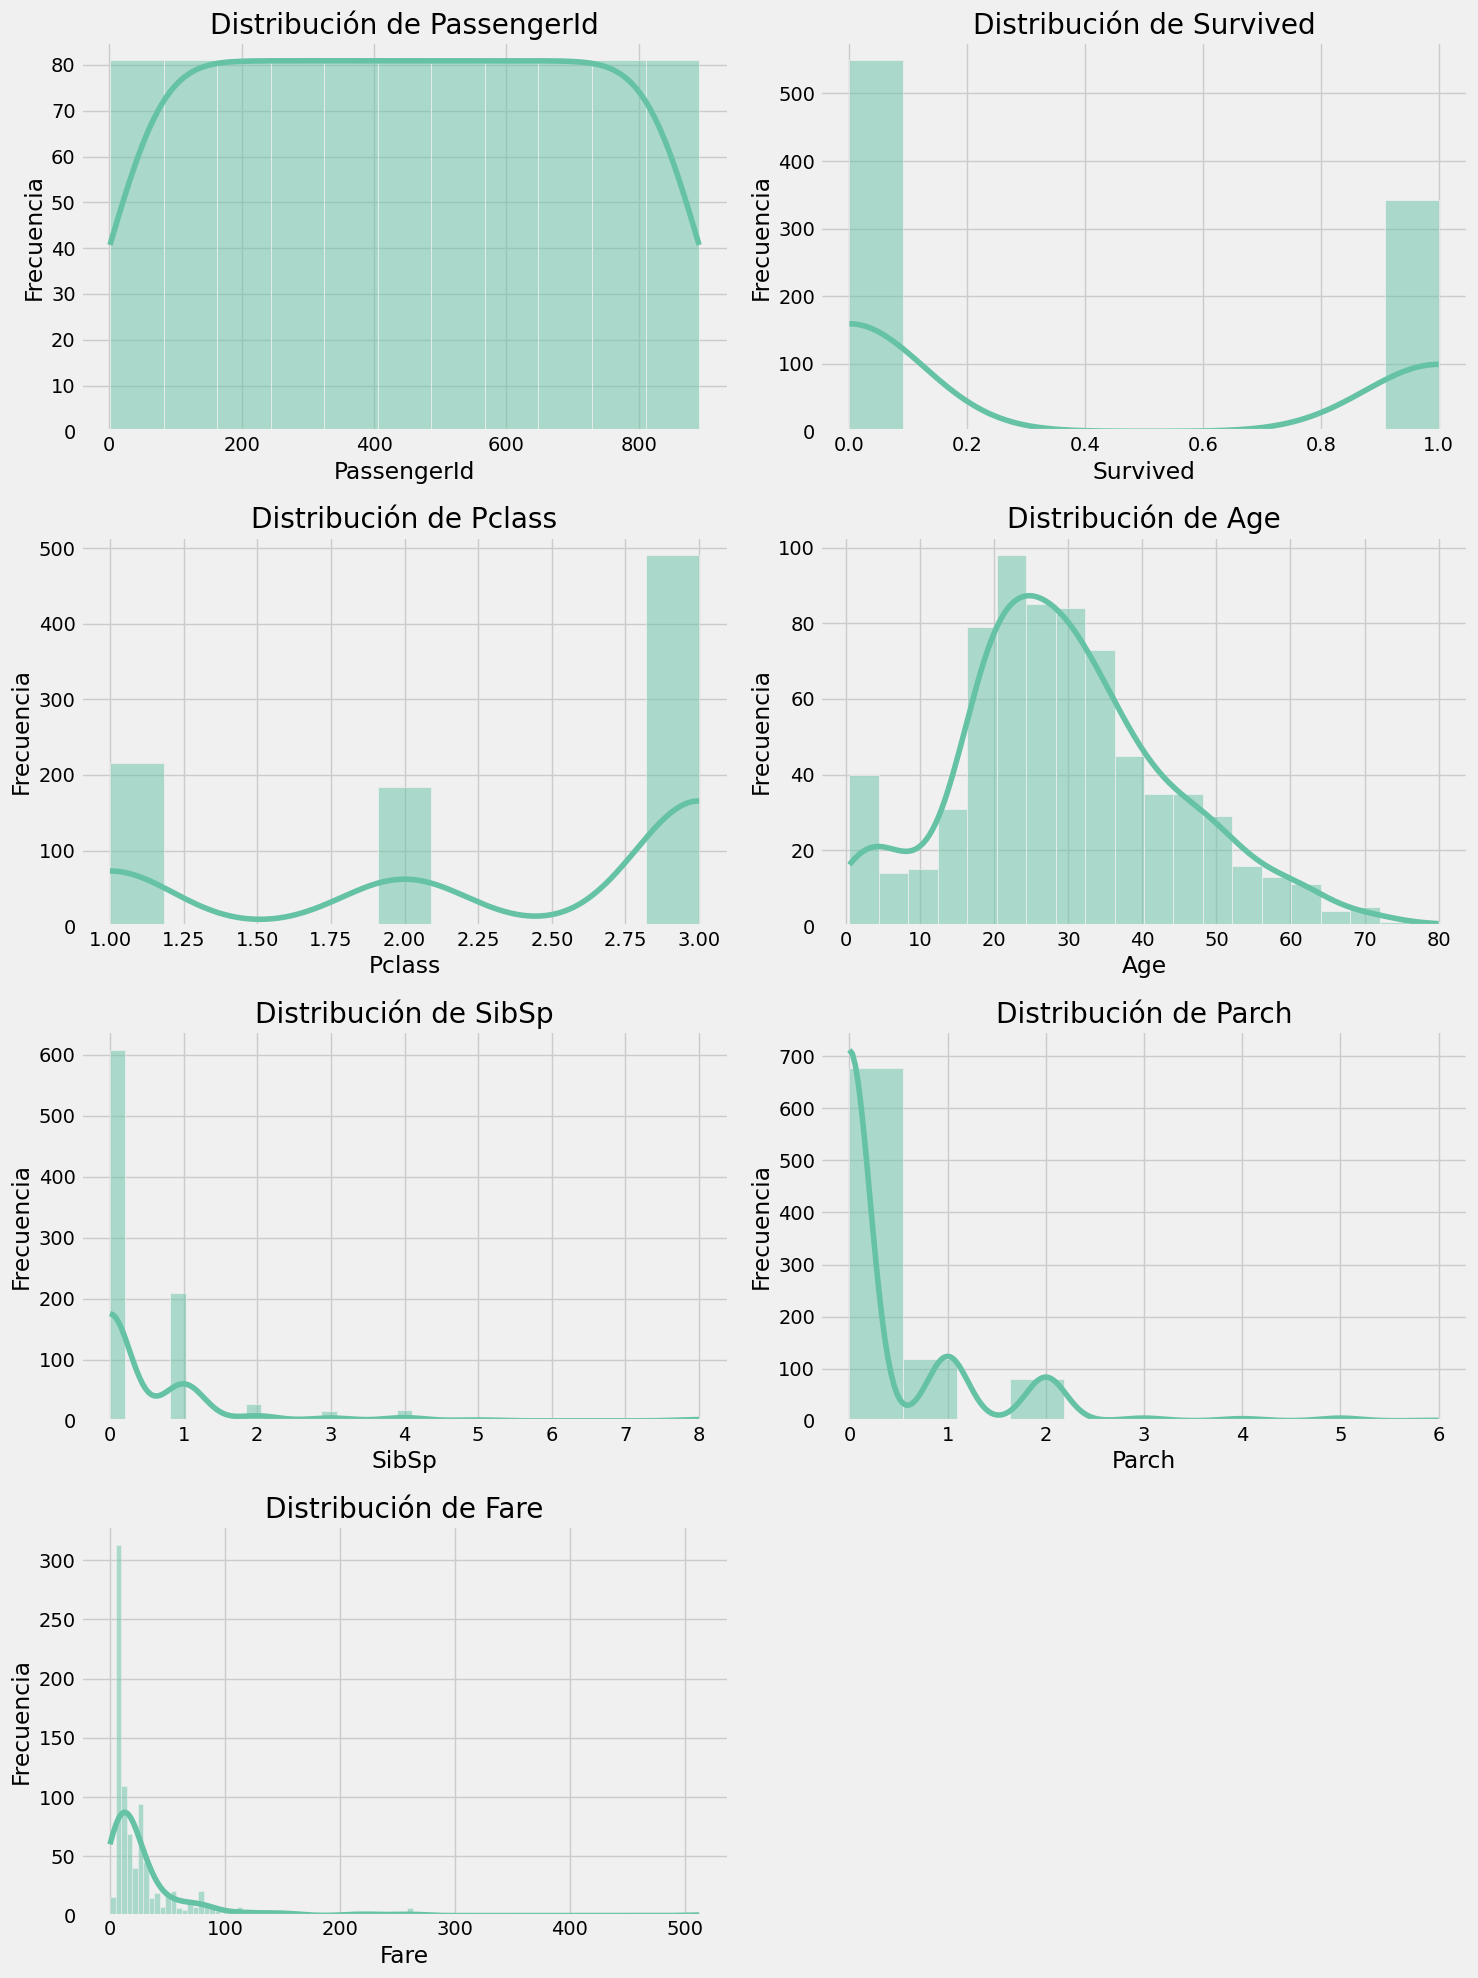

In [88]:
# Visualización de distribuciones numéricas
n_cols = len(numeric_cols)
n_rows = (n_cols + 1) // 2
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### 1.1.5 Análisis de Variables Categóricas
Exploramos las variables categóricas para comprender su distribución y la presencia de valores faltantes.

In [89]:
# Análisis de variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("3. Análisis de Variables Categóricas:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Valores únicos: {df[col].nunique()}")
    print(f"Valores faltantes: {df[col].isnull().sum()}")

3. Análisis de Variables Categóricas:

Name:
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Hewlett, Mrs. (Mary D Kingcome)                        1
Vestrom, Miss. Hulda Amanda Adolfina                   1
Andersson, Mr. Anders Johan                            1
Saundercock, Mr. William Henry                         1
Bonnell, Miss. Elizabeth                               1
Name: count, Length: 891, dtype: int64
Valores únicos: 891
Valores faltantes: 0

Sex:
Sex
male      577
female    314
Name: count, dtype: int64
Valores únicos: 2
Valores faltantes: 0

Ticket:
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
              

### 1.1.6 Relaciones con la Variable Objetivo (Supervivencia)
Analizamos cómo se relacionan las diferentes variables con la supervivencia para entender qué factores podrían ser importantes para la imputación.

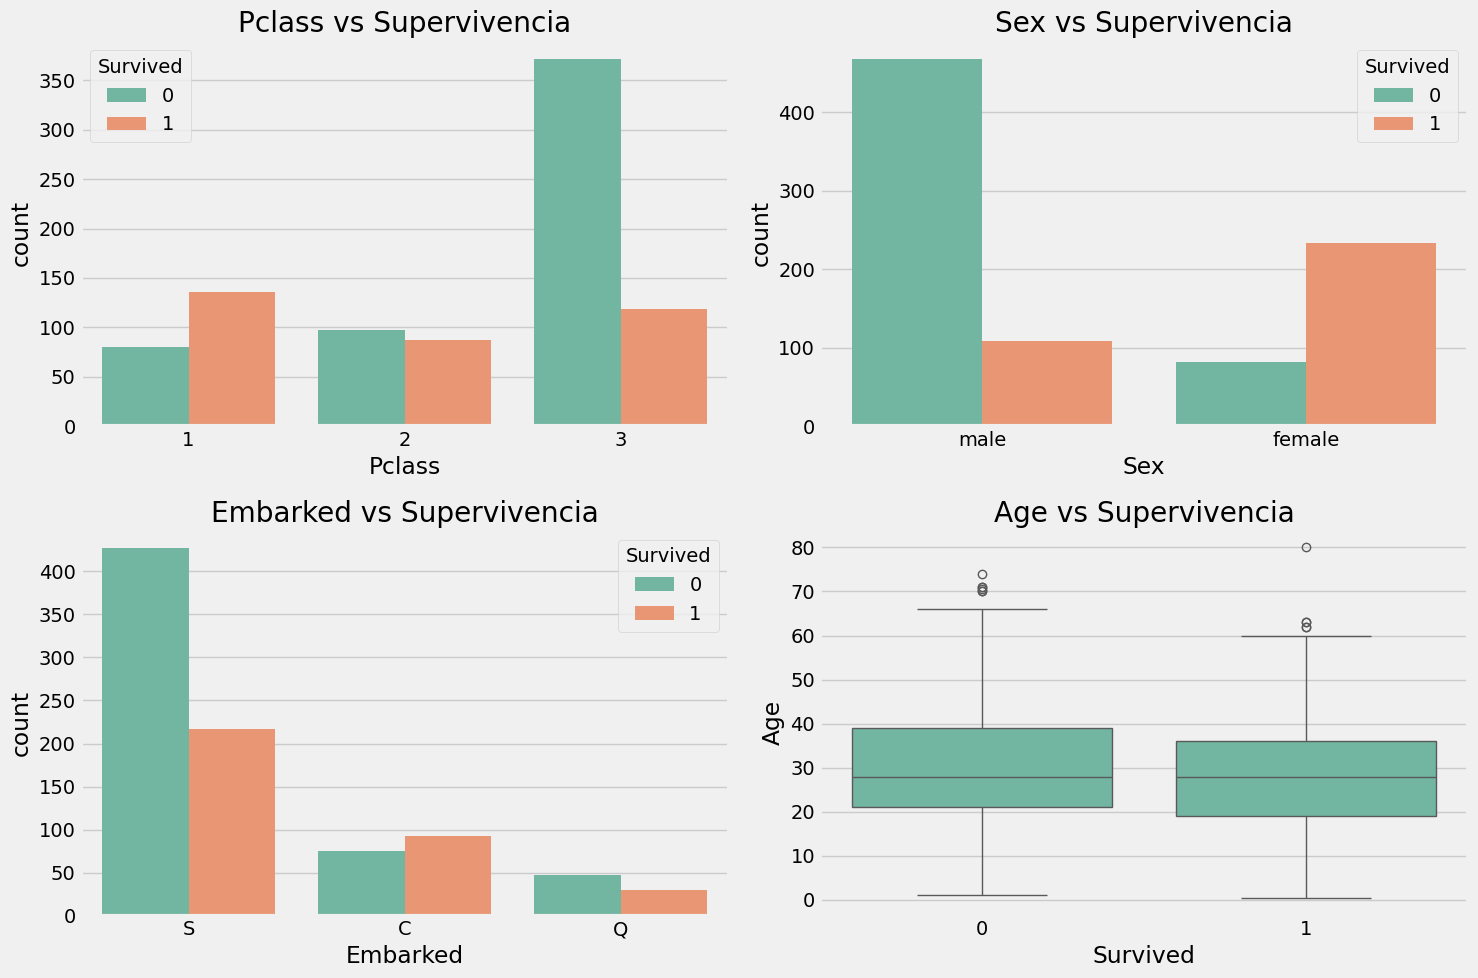

In [90]:
# Visualización de relaciones con la supervivencia
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Pclass', 'Sex', 'Embarked', 'Age'], 1):
    plt.subplot(2, 2, i)
    if col == 'Age':
        sns.boxplot(x='Survived', y=col, data=df)
    else:
        sns.countplot(data=df, x=col, hue='Survived')
    plt.title(f'{col} vs Supervivencia')
plt.tight_layout()
plt.show()

### 1.1.7 Matriz de Correlación
Examinamos las correlaciones entre variables numéricas para identificar relaciones que puedan ser útiles en el proceso de imputación.

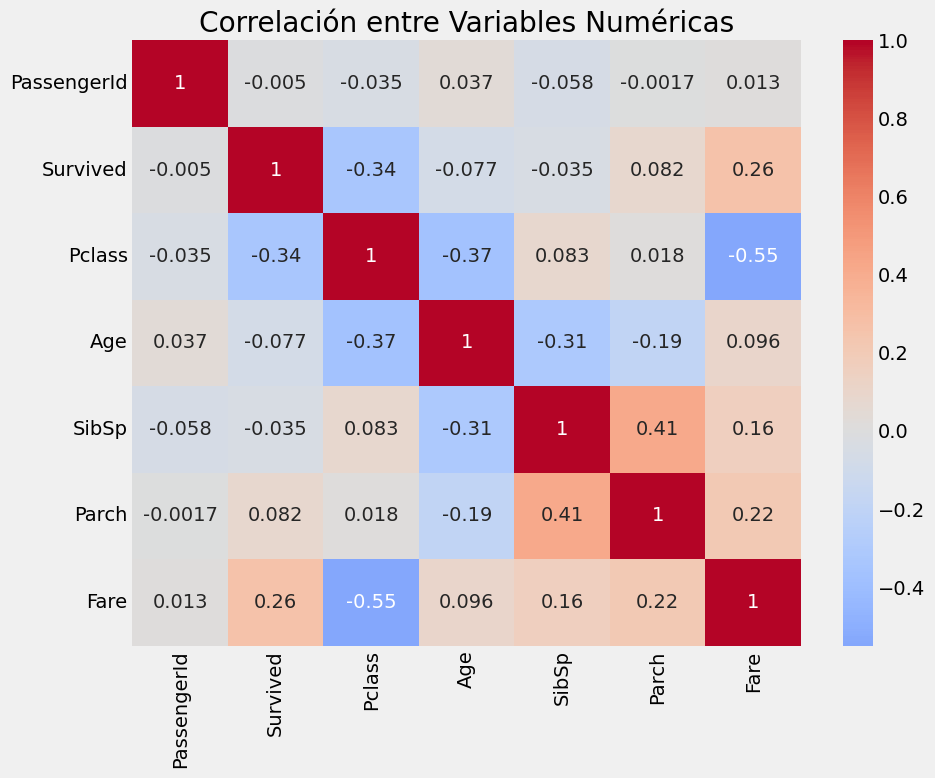

In [91]:
# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()

## 1.2 Análisis de Casos Completos vs Incompletos
Vamos a comparar las distribuciones entre casos completos e incompletos para entender mejor el impacto de los valores faltantes.


Análisis para la variable: Cabin

Resultados de pruebas estadísticas:
      Variable  T-statistic        P-value
0  PassengerId     0.594026   5.526459e-01
1     Survived     9.962587   3.090891e-22
2       Pclass   -31.434877  1.917128e-146
3          Age     6.881736   1.297784e-11
4        SibSp    -1.207348   2.276191e-01
5        Parch     1.103564   2.700808e-01
6         Fare    16.405799   4.852805e-53

Análisis para la variable: Age

Resultados de pruebas estadísticas:
      Variable  T-statistic       P-value
0  PassengerId     0.601420  5.477139e-01
1     Survived     2.760699  5.886535e-03
2       Pclass    -5.235057  2.059182e-07
3        SibSp    -0.565342  5.719835e-01
4        Parch     3.729121  2.043178e-04
5         Fare     3.018037  2.616756e-03


C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:


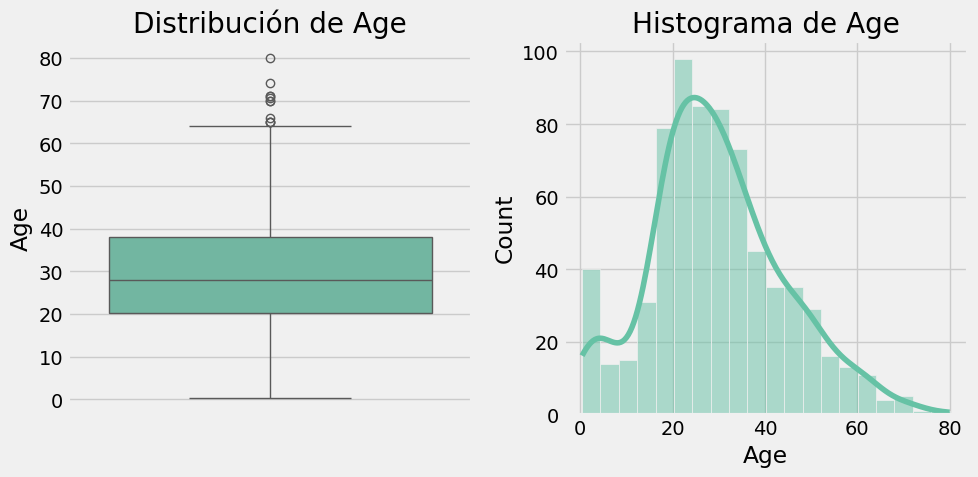


Análisis para la variable: Embarked

Resultados de pruebas estadísticas:
      Variable  T-statistic   P-value
0  PassengerId     0.000000  1.000000
1     Survived    -1.795038  0.072987
2       Pclass     2.220946  0.026606
3          Age    -1.983214  0.047727
4        SibSp     0.671278  0.502218
5        Parch     0.670045  0.503003
6         Fare    -1.362393  0.173419


c:\Users\rgarz\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\3709152316.py:36: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[var].dtype in [np.number]:


In [92]:
# Función para realizar pruebas estadísticas entre casos completos e incompletos
def analizar_casos(data, variable):
    # Crear máscara de valores faltantes
    missing_mask = data[variable].isnull()

    # Seleccionar variables numéricas para comparación
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    results = []
    for col in numeric_cols:
        if col != variable:
            # Realizar prueba t de Student
            complete = data[~missing_mask][col].dropna()
            incomplete = data[missing_mask][col].dropna()

            if len(complete) > 0 and len(incomplete) > 0:
                t_stat, p_value = stats.ttest_ind(complete, incomplete)
                results.append({
                    'Variable': col,
                    'T-statistic': t_stat,
                    'P-value': p_value
                })

    return pd.DataFrame(results)

# Analizar cada variable con valores faltantes
variables_faltantes = missing_info[missing_info['Valores Faltantes'] > 0].index

for var in variables_faltantes:
    print(f"\nAnálisis para la variable: {var}")
    resultados = analizar_casos(df, var)
    print("\nResultados de pruebas estadísticas:")
    print(resultados)

    # Visualizar distribuciones si la variable es numérica
    if df[var].dtype in [np.number]:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df, y=var)
        plt.title(f'Distribución de {var}')

        plt.subplot(1, 2, 2)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'Histograma de {var}')
        plt.tight_layout()
        plt.show()

## 1.3 Correlación con Otras Variables
Analizaremos si la ausencia de valores está relacionada con otras variables en el dataset.

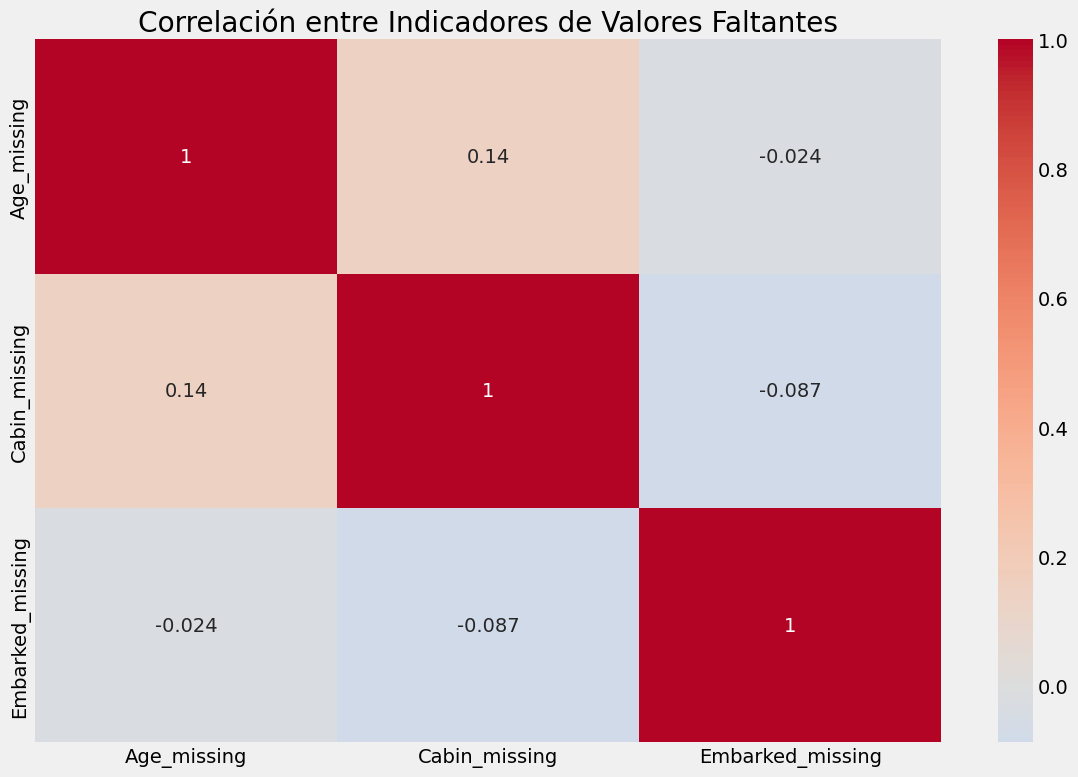


Análisis de correlación para valores faltantes en Age:
Correlación con PassengerId: -0.020
Correlación con Survived: -0.092
Correlación con Pclass: 0.173
Correlación con SibSp: 0.019
Correlación con Parch: -0.124
Correlación con Fare: -0.101

Análisis de correlación para valores faltantes en Cabin:
Correlación con PassengerId: -0.020
Correlación con Survived: -0.317
Correlación con Pclass: 0.726
Correlación con Age: -0.233
Correlación con SibSp: 0.040
Correlación con Parch: -0.037
Correlación con Fare: -0.482

Análisis de correlación para valores faltantes en Embarked:
Correlación con PassengerId: -0.000
Correlación con Survived: 0.060
Correlación con Pclass: -0.074
Correlación con Age: 0.074
Correlación con SibSp: -0.023
Correlación con Parch: -0.022
Correlación con Fare: 0.046


In [93]:
# Crear indicadores de missingness
missing_indicators = pd.DataFrame()

for col in df.columns:
    if df[col].isnull().any():
        missing_indicators[f'{col}_missing'] = df[col].isnull().astype(int)

# Calcular matriz de correlación entre indicadores
corr_matrix = missing_indicators.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Indicadores de Valores Faltantes')
plt.tight_layout()
plt.show()

# Analizar relación entre valores faltantes y variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in df.columns:
    if df[col].isnull().any():
        print(f"\nAnálisis de correlación para valores faltantes en {col}:")
        missing_mask = df[col].isnull()

        for num_col in numeric_cols:
            if num_col != col:
                correlation = np.corrcoef(missing_mask, df[num_col].fillna(df[num_col].mean()))[0,1]
                print(f"Correlación con {num_col}: {correlation:.3f}")

## 1.4 Prueba de Little's MCAR
Implementamos el test de Little para determinar si los valores faltantes siguen un patrón completamente aleatorio (MCAR).

In [94]:
# Implementación del test de Little's MCAR usando solo librerías estándar
def littles_mcar_test(data):
    """
    Test de Little para MCAR (Missing Completely at Random)
    
    H0: Los datos son MCAR (Missing Completely at Random)
    H1: Los datos no son MCAR
    
    Implementación usando solo pandas, numpy y scipy
    """
    from scipy.stats import chi2
    
    print("=== TEST DE LITTLE'S MCAR ===")
    
    # 1. Preparar datos - solo variables numéricas
    numeric_data = data.select_dtypes(include=[np.number])
    n_obs, n_vars = numeric_data.shape
    
    print(f"Datos analizados: {n_obs} observaciones, {n_vars} variables numéricas")
    print(f"Variables incluidas: {list(numeric_data.columns)}")
    
    # 2. Crear matriz de indicadores de missingness
    missing_matrix = numeric_data.isnull()
    
    # 3. Identificar patrones únicos de missingness
    patterns = missing_matrix.drop_duplicates()
    n_patterns = len(patterns)
    
    print(f"\\nNúmero de patrones de missingness únicos: {n_patterns}")
    
    # 4. Analizar cada patrón
    pattern_analysis = []
    total_missing = 0
    
    for i, (pattern_idx, pattern) in enumerate(patterns.iterrows()):
        # Contar observaciones con este patrón
        pattern_match = (missing_matrix == pattern).all(axis=1)
        count = pattern_match.sum()
        
        # Identificar variables faltantes en este patrón
        missing_vars = pattern[pattern == True].index.tolist()
        
        pattern_info = {
            'Patrón': i + 1,
            'Variables_Faltantes': missing_vars if missing_vars else 'Ninguna (Completo)',
            'Frecuencia': count,
            'Porcentaje': (count / n_obs) * 100
        }
        
        pattern_analysis.append(pattern_info)
        
        if missing_vars:  # Si hay variables faltantes
            total_missing += count
    
    # 5. Mostrar análisis de patrones
    pattern_df = pd.DataFrame(pattern_analysis).sort_values('Frecuencia', ascending=False)
    print("\\nAnálisis de Patrones de Missingness:")
    print(pattern_df.to_string(index=False))
    
    # 6. Estadísticas de missingness por variable
    print("\\n=== ESTADÍSTICAS POR VARIABLE ===")
    for col in numeric_data.columns:
        missing_count = numeric_data[col].isnull().sum()
        missing_pct = (missing_count / n_obs) * 100
        print(f"{col}: {missing_count}/{n_obs} ({missing_pct:.1f}%) valores faltantes")
    
    # 7. Test de independencia simplificado
    print("\\n=== TESTS DE INDEPENDENCIA ===")
    
    # Para cada par de variables, testear si el missingness es independiente
    missing_vars = [col for col in numeric_data.columns if numeric_data[col].isnull().any()]
    
    if len(missing_vars) >= 2:
        print("Tests de independencia entre patrones de missingness:")
        
        for i, var1 in enumerate(missing_vars):
            for var2 in missing_vars[i+1:]:
                # Crear tabla de contingencia
                contingency = pd.crosstab(
                    numeric_data[var1].isnull(), 
                    numeric_data[var2].isnull()
                )
                
                # Chi-cuadrado test
                from scipy.stats import chi2_contingency
                if contingency.shape == (2, 2) and contingency.min().min() >= 5:
                    chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
                    print(f"  {var1} vs {var2}: χ² = {chi2_stat:.3f}, p = {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print(f"    ⚠️  Dependencia significativa (no independiente)")
                    else:
                        print(f"    ✅ Independientes (compatible con MCAR)")
                else:
                    print(f"  {var1} vs {var2}: Muestra insuficiente para test")
    
    # 8. Interpretación general
    print("\\n=== INTERPRETACIÓN GENERAL ===")
    
    complete_cases_pct = pattern_df[pattern_df['Variables_Faltantes'] == 'Ninguna (Completo)']['Porcentaje'].iloc[0] if len(pattern_df[pattern_df['Variables_Faltantes'] == 'Ninguna (Completo)']) > 0 else 0
    
    print(f"Casos completos: {complete_cases_pct:.1f}%")
    print(f"Casos con algún valor faltante: {100 - complete_cases_pct:.1f}%")
    
    # Interpretación heurística basada en patrones
    if n_patterns <= 2:
        conclusion = "PROBABLE MCAR"
        explanation = "Pocos patrones de missingness, sugiere aleatoriedad"
    elif n_patterns <= 4:
        conclusion = "POSIBLE MAR"
        explanation = "Patrones moderados, podría depender de variables observadas"
    else:
        conclusion = "POSIBLE MNAR"
        explanation = "Múltiples patrones complejos, sugiere mecanismos sistemáticos"
    
    print(f"\\n🔍 CONCLUSIÓN PRELIMINAR: {conclusion}")
    print(f"📊 JUSTIFICACIÓN: {explanation}")
    
    print("\\n⚠️  NOTA IMPORTANTE:")
    print("Este es un test simplificado. El test formal de Little requiere:")
    print("- Cálculo de estadístico de verosimilitud complejo")
    print("- Distribución chi-cuadrado con grados de libertad específicos") 
    print("- Para análisis definitivo, considerar implementaciones especializadas")
    
    return pattern_df

# Ejecutar el test mejorado
print("Ejecutando Test de Little's MCAR con implementación propia...")
littles_result = littles_mcar_test(df)

# Análisis complementario de aleatoriedad
print("\\n" + "="*60)
print("ANÁLISIS COMPLEMENTARIO DE ALEATORIEDAD")
print("="*60)

for col in ['Age', 'Cabin', 'Embarked']:
    if df[col].isnull().any():
        missing_pct = df[col].isnull().mean() * 100
        print(f"\\n{col.upper()}: {missing_pct:.1f}% valores faltantes")
        
        # Test de independencia con variables categóricas
        categorical_vars = ['Sex', 'Pclass']
        
        for cat_var in categorical_vars:
            if col != cat_var:
                try:
                    contingency = pd.crosstab(df[cat_var], df[col].isnull())
                    from scipy.stats import chi2_contingency
                    chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
                    
                    print(f"  Chi² test con {cat_var}: χ² = {chi2_stat:.3f}, p = {p_value:.4f}")
                    
                    if p_value < 0.05:
                        print(f"    ⚠️  Dependencia significativa con {cat_var} (NO es MCAR)")
                    else:
                        print(f"    ✅ Independiente de {cat_var} (compatible con MCAR)")
                        
                except Exception as e:
                    print(f"  Error en test con {cat_var}: {str(e)}")

print("\\n" + "="*60)

Ejecutando Test de Little's MCAR con implementación propia...
=== TEST DE LITTLE'S MCAR ===
Datos analizados: 891 observaciones, 7 variables numéricas
Variables incluidas: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
\nNúmero de patrones de missingness únicos: 2
\nAnálisis de Patrones de Missingness:
 Patrón Variables_Faltantes  Frecuencia  Porcentaje
      1  Ninguna (Completo)         714    80.13468
      2               [Age]         177    19.86532
\n=== ESTADÍSTICAS POR VARIABLE ===
PassengerId: 0/891 (0.0%) valores faltantes
Survived: 0/891 (0.0%) valores faltantes
Pclass: 0/891 (0.0%) valores faltantes
Age: 177/891 (19.9%) valores faltantes
SibSp: 0/891 (0.0%) valores faltantes
Parch: 0/891 (0.0%) valores faltantes
Fare: 0/891 (0.0%) valores faltantes
\n=== TESTS DE INDEPENDENCIA ===
\n=== INTERPRETACIÓN GENERAL ===
Casos completos: 80.1%
Casos con algún valor faltante: 19.9%
\n🔍 CONCLUSIÓN PRELIMINAR: PROBABLE MCAR
📊 JUSTIFICACIÓN: Pocos patrones de m

## 1.5 Análisis Individual por Variable con Valores Faltantes
Analizamos cada variable con missingness de forma individual para determinar el tipo de patrón y sus implicaciones.

### 1.5.1 Análisis de la Variable 'Age' (19.9% missing)

=== ANÁLISIS DETALLADO: VARIABLE 'AGE' ===
Valores faltantes: 177 de 891 (19.9%)

--- Análisis por Sexo ---
male: 124 missing de 577 (21.5%)
female: 53 missing de 314 (16.9%)

--- Análisis por Clase ---
Clase 1: 30 missing de 216 (13.9%)
Clase 2: 11 missing de 184 (6.0%)
Clase 3: 136 missing de 491 (27.7%)

--- Análisis por Supervivencia ---
No Sobrevivió: 125 missing de 549 (22.8%)
Sobrevivió: 52 missing de 342 (15.2%)

--- Tests Estadísticos ---
Chi2 test Age vs Pclass: χ² = 46.063, p = 0.0000
Chi2 test Age vs Sex: χ² = 2.434, p = 0.1187

--- CONCLUSIÓN PARA 'AGE' ---
🔍 TIPO: MAR (Missing at Random)
📊 EVIDENCIA: Dependencia significativa con otras variables
⚠️  SESGO: Posible sesgo si se elimina completamente
💡 RECOMENDACIÓN: Imputación basada en grupos demográficos


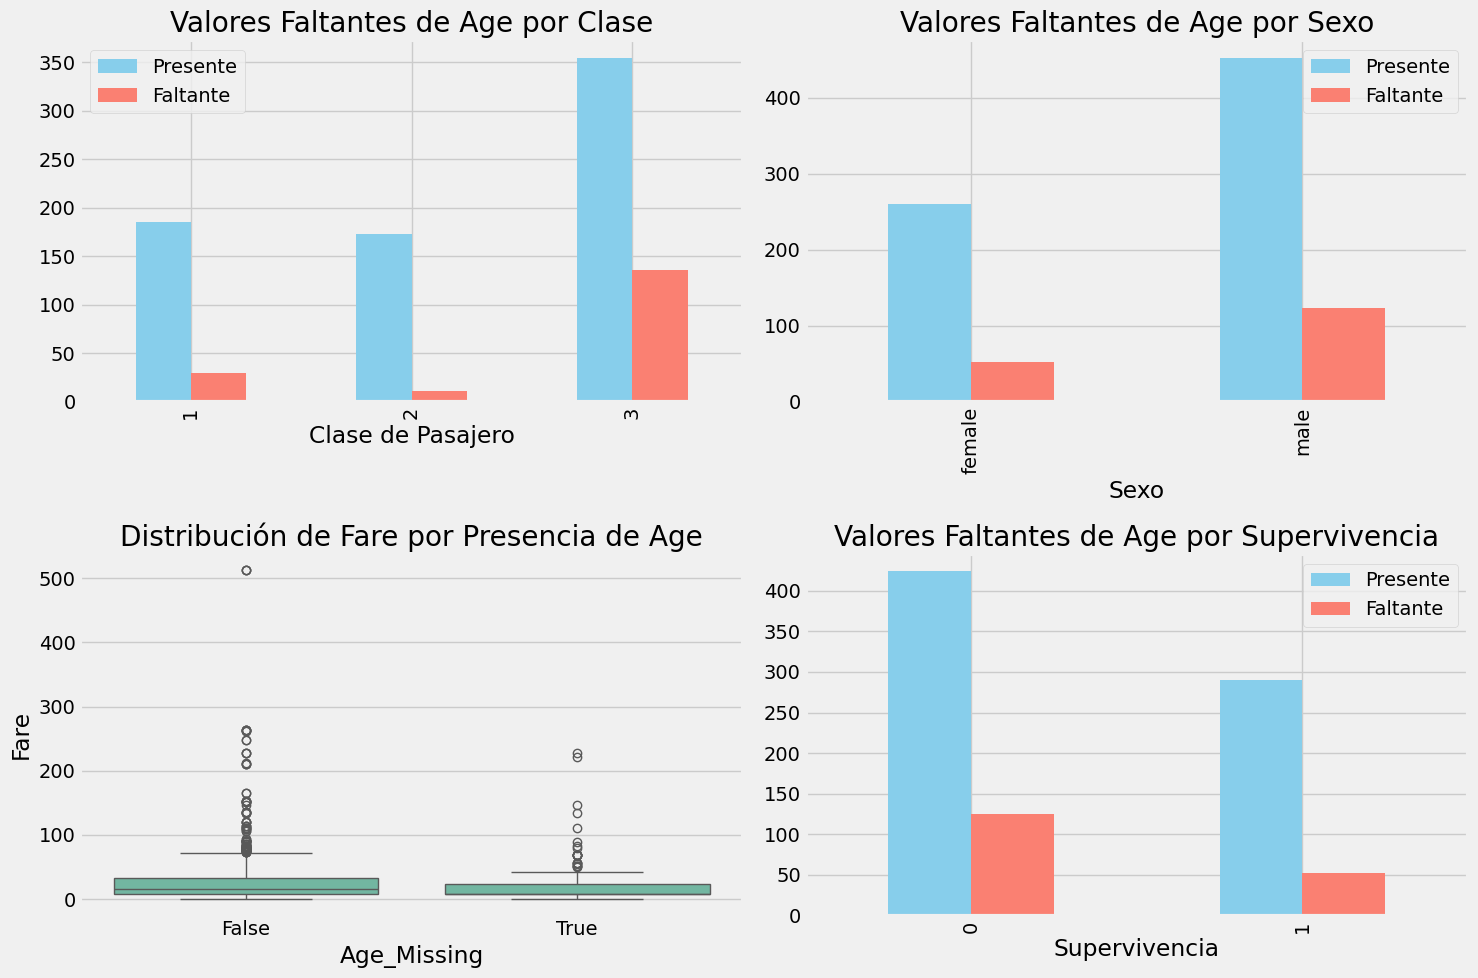

In [95]:
def analizar_variable_edad():
    print("=== ANÁLISIS DETALLADO: VARIABLE 'AGE' ===")
    
    # 1. Estadísticas básicas
    age_missing = df['Age'].isnull().sum()
    age_total = len(df)
    age_missing_pct = (age_missing / age_total) * 100
    
    print(f"Valores faltantes: {age_missing} de {age_total} ({age_missing_pct:.1f}%)")
    
    # 2. Análisis por grupo demográfico
    print("\n--- Análisis por Sexo ---")
    sex_age_missing = df.groupby('Sex')['Age'].apply(lambda x: x.isnull().sum())
    sex_totals = df.groupby('Sex').size()
    sex_age_missing_pct = (sex_age_missing / sex_totals * 100).round(1)
    
    for sex in ['male', 'female']:
        print(f"{sex}: {sex_age_missing[sex]} missing de {sex_totals[sex]} ({sex_age_missing_pct[sex]}%)")
    
    print("\n--- Análisis por Clase ---")
    class_age_missing = df.groupby('Pclass')['Age'].apply(lambda x: x.isnull().sum())
    class_totals = df.groupby('Pclass').size()
    class_age_missing_pct = (class_age_missing / class_totals * 100).round(1)
    
    for pclass in [1, 2, 3]:
        print(f"Clase {pclass}: {class_age_missing[pclass]} missing de {class_totals[pclass]} ({class_age_missing_pct[pclass]}%)")
    
    # 3. Análisis de supervivencia
    print("\n--- Análisis por Supervivencia ---")
    survived_age_missing = df.groupby('Survived')['Age'].apply(lambda x: x.isnull().sum())
    survived_totals = df.groupby('Survived').size()
    survived_age_missing_pct = (survived_age_missing / survived_totals * 100).round(1)
    
    for survived in [0, 1]:
        status = "No Sobrevivió" if survived == 0 else "Sobrevivió"
        print(f"{status}: {survived_age_missing[survived]} missing de {survived_totals[survived]} ({survived_age_missing_pct[survived]}%)")
    
    # 4. Test estadísticos
    print("\n--- Tests Estadísticos ---")
    
    # Chi-cuadrado para independencia con Pclass
    from scipy.stats import chi2_contingency
    contingency_class = pd.crosstab(df['Pclass'], df['Age'].isnull())
    chi2_class, p_class, _, _ = chi2_contingency(contingency_class)
    print(f"Chi2 test Age vs Pclass: χ² = {chi2_class:.3f}, p = {p_class:.4f}")
    
    # Chi-cuadrado para independencia con Sex
    contingency_sex = pd.crosstab(df['Sex'], df['Age'].isnull())
    chi2_sex, p_sex, _, _ = chi2_contingency(contingency_sex)
    print(f"Chi2 test Age vs Sex: χ² = {chi2_sex:.3f}, p = {p_sex:.4f}")
    
    # 5. Conclusión para Age
    print("\n--- CONCLUSIÓN PARA 'AGE' ---")
    if p_class < 0.05 or p_sex < 0.05:
        print("🔍 TIPO: MAR (Missing at Random)")
        print("📊 EVIDENCIA: Dependencia significativa con otras variables")
        print("⚠️  SESGO: Posible sesgo si se elimina completamente")
        print("💡 RECOMENDACIÓN: Imputación basada en grupos demográficos")
    else:
        print("🔍 TIPO: MCAR (Missing Completely at Random)")
        print("📊 EVIDENCIA: No hay dependencia significativa")
        print("✅ SESGO: Mínimo sesgo esperado")
        print("💡 RECOMENDACIÓN: Imputación simple o eliminación")

analizar_variable_edad()

# Visualización específica para Age
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribución de Age missing por Pclass
df_age_pclass = df.groupby(['Pclass', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_pclass.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Valores Faltantes de Age por Clase')
axes[0,0].set_xlabel('Clase de Pasajero')
axes[0,0].legend(['Presente', 'Faltante'])

# 2. Distribución de Age missing por Sex
df_age_sex = df.groupby(['Sex', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_sex.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'salmon'])
axes[0,1].set_title('Valores Faltantes de Age por Sexo')
axes[0,1].set_xlabel('Sexo')
axes[0,1].legend(['Presente', 'Faltante'])

# 3. Boxplot de otras variables por missing Age
df_temp = df.copy()
df_temp['Age_Missing'] = df_temp['Age'].isnull()
sns.boxplot(data=df_temp, x='Age_Missing', y='Fare', ax=axes[1,0])
axes[1,0].set_title('Distribución de Fare por Presencia de Age')

# 4. Distribución de supervivencia por missing Age
df_age_survived = df.groupby(['Survived', df['Age'].isnull()]).size().unstack(fill_value=0)
df_age_survived.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'salmon'])
axes[1,1].set_title('Valores Faltantes de Age por Supervivencia')
axes[1,1].set_xlabel('Supervivencia')
axes[1,1].legend(['Presente', 'Faltante'])

plt.tight_layout()
plt.show()

### 1.5.2 Análisis de la Variable 'Cabin' (77.1% missing)

=== ANÁLISIS DETALLADO: VARIABLE 'CABIN' ===
Valores faltantes: 687 de 891 (77.1%)

--- Análisis por Clase de Pasajero ---
Clase 1: 40 missing de 216 (18.5%) - 176 presentes
Clase 2: 168 missing de 184 (91.3%) - 16 presentes
Clase 3: 479 missing de 491 (97.6%) - 12 presentes

--- Análisis por Rango de Tarifa ---
               Missing  Total  Missing_Pct
Fare_Quartile                             
Q1(Bajo)           215    223         96.4
Q2                 208    224         92.9
Q3                 181    222         81.5
Q4(Alto)            83    222         37.4

--- Análisis de Cabinas Existentes ---
Distribución por cubierta:
Cabin
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: count, dtype: int64

--- Tests Estadísticos ---
Chi2 test Cabin vs Pclass: χ² = 557.310, p = 0.0000
Correlación Cabin Missing vs Fare: r = -0.482

--- CONTEXTO HISTÓRICO DEL TITANIC ---
🚢 En el Titanic, las cabinas se asignaban según la clase del boleto:
   - Primera clase: Cabinas de

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\4061712416.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_cabin_analysis = df_temp.groupby('Fare_Quartile').agg({


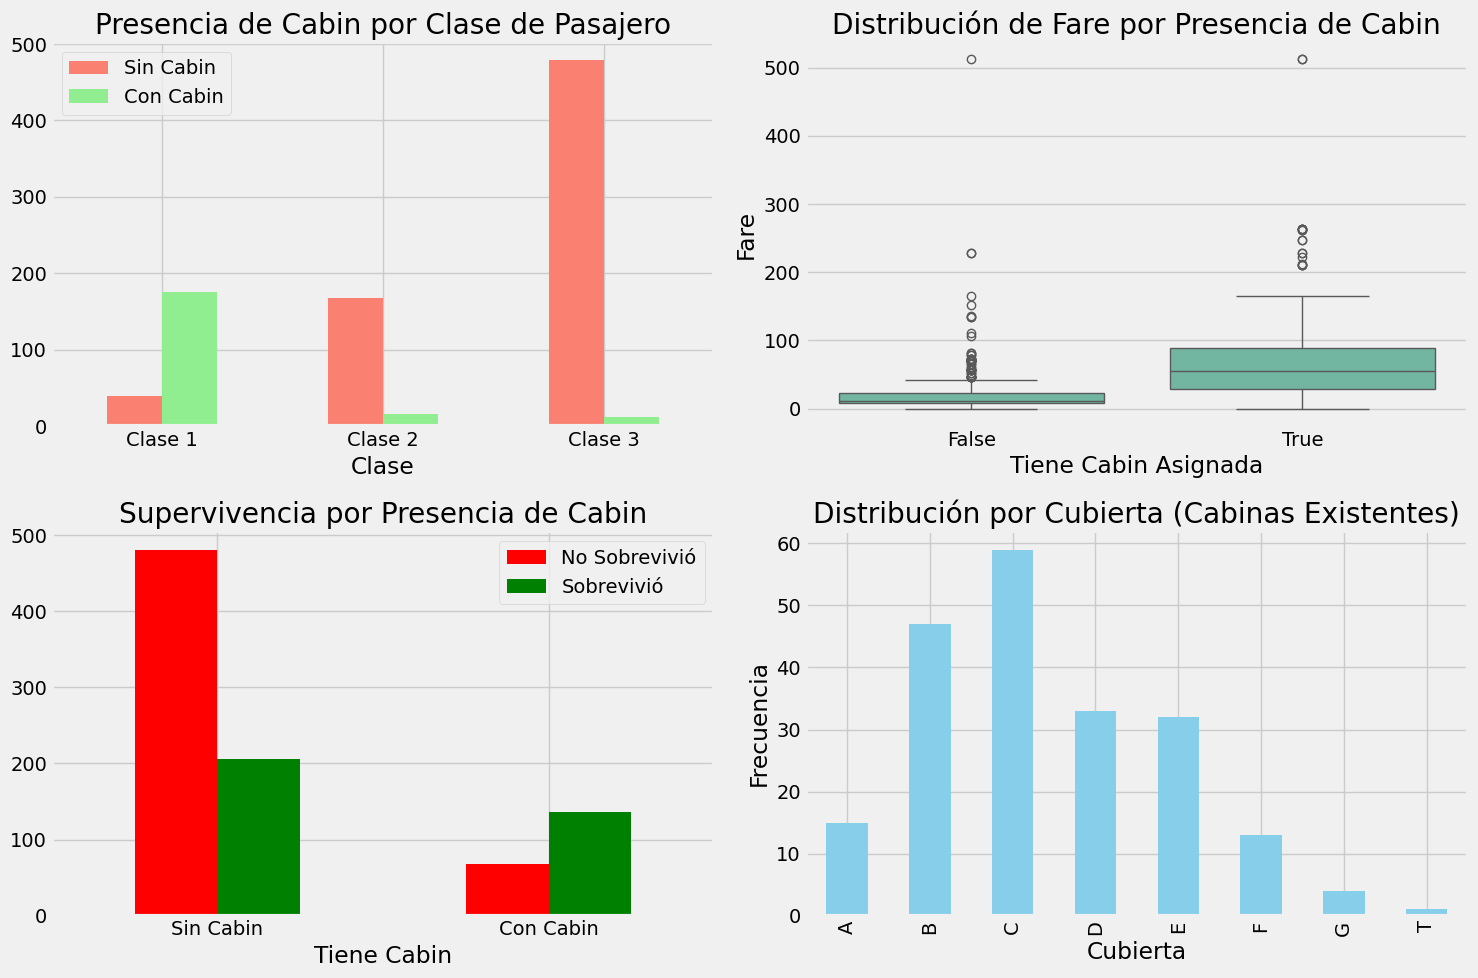

In [96]:
def analizar_variable_cabin():
    print("=== ANÁLISIS DETALLADO: VARIABLE 'CABIN' ===")
    
    # 1. Estadísticas básicas
    cabin_missing = df['Cabin'].isnull().sum()
    cabin_total = len(df)
    cabin_missing_pct = (cabin_missing / cabin_total) * 100
    
    print(f"Valores faltantes: {cabin_missing} de {cabin_total} ({cabin_missing_pct:.1f}%)")
    
    # 2. Análisis por clase socioeconómica (Pclass)
    print("\n--- Análisis por Clase de Pasajero ---")
    cabin_by_class = df.groupby('Pclass')['Cabin'].apply(lambda x: x.isnull().sum())
    class_totals = df.groupby('Pclass').size()
    cabin_missing_pct_class = (cabin_by_class / class_totals * 100).round(1)
    
    for pclass in [1, 2, 3]:
        present = class_totals[pclass] - cabin_by_class[pclass]
        print(f"Clase {pclass}: {cabin_by_class[pclass]} missing de {class_totals[pclass]} ({cabin_missing_pct_class[pclass]}%) - {present} presentes")
    
    # 3. Análisis por tarifa (como proxy de estatus económico)
    print("\n--- Análisis por Rango de Tarifa ---")
    df_temp = df.copy()
    df_temp['Fare_Quartile'] = pd.qcut(df_temp['Fare'], q=4, labels=['Q1(Bajo)', 'Q2', 'Q3', 'Q4(Alto)'])
    
    fare_cabin_analysis = df_temp.groupby('Fare_Quartile').agg({
        'Cabin': lambda x: x.isnull().sum(),
        'PassengerId': 'count'
    })
    fare_cabin_analysis['Missing_Pct'] = (fare_cabin_analysis['Cabin'] / fare_cabin_analysis['PassengerId'] * 100).round(1)
    print(fare_cabin_analysis.rename(columns={'Cabin': 'Missing', 'PassengerId': 'Total'}))
    
    # 4. Análisis de patrones en cabinas existentes
    print("\n--- Análisis de Cabinas Existentes ---")
    existing_cabins = df[df['Cabin'].notna()]['Cabin']
    
    # Extraer letra de cubierta
    cabin_decks = existing_cabins.str[0]
    print("Distribución por cubierta:")
    print(cabin_decks.value_counts().sort_index())
    
    # 5. Test estadísticos
    print("\n--- Tests Estadísticos ---")
    
    # Chi-cuadrado para independencia con Pclass (muy importante para cabinas)
    from scipy.stats import chi2_contingency
    contingency_class = pd.crosstab(df['Pclass'], df['Cabin'].isnull())
    chi2_class, p_class, _, _ = chi2_contingency(contingency_class)
    print(f"Chi2 test Cabin vs Pclass: χ² = {chi2_class:.3f}, p = {p_class:.4f}")
    
    # Correlación con Fare
    cabin_missing_indicator = df['Cabin'].isnull().astype(int)
    fare_correlation = np.corrcoef(cabin_missing_indicator, df['Fare'])[0,1]
    print(f"Correlación Cabin Missing vs Fare: r = {fare_correlation:.3f}")
    
    # 6. Interpretación contextual del Titanic
    print("\n--- CONTEXTO HISTÓRICO DEL TITANIC ---")
    print("🚢 En el Titanic, las cabinas se asignaban según la clase del boleto:")
    print("   - Primera clase: Cabinas de lujo con identificación específica")
    print("   - Segunda clase: Cabinas estándar con numeración")
    print("   - Tercera clase: Compartimientos generales, sin asignación individual")
    print("   - Muchos pasajeros de tercera clase no tenían cabinas específicas asignadas")
    
    # 7. Conclusión para Cabin
    print("\n--- CONCLUSIÓN PARA 'CABIN' ---")
    if p_class < 0.001:  # Muy significativo
        print("🔍 TIPO: MNAR (Missing Not at Random)")
        print("📊 EVIDENCIA: Fuerte dependencia con clase socioeconómica")
        print("🏛️  MECANISMO: Ausencia sistemática por diseño del sistema de cabinas")
        print("⚠️  SESGO: Alto sesgo si se elimina - perdemos info de clase social")
        print("💡 RECOMENDACIÓN: Crear indicador 'Has_Cabin' + imputación por grupos")
    else:
        print("🔍 TIPO: MAR")
        print("💡 RECOMENDACIÓN: Imputación basada en características observadas")

analizar_variable_cabin()

# Visualización específica para Cabin
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Presencia de Cabin por Clase
cabin_by_class_viz = df.groupby(['Pclass', df['Cabin'].notna()]).size().unstack(fill_value=0)
cabin_by_class_viz.plot(kind='bar', ax=axes[0,0], color=['salmon', 'lightgreen'])
axes[0,0].set_title('Presencia de Cabin por Clase de Pasajero')
axes[0,0].set_xlabel('Clase')
axes[0,0].legend(['Sin Cabin', 'Con Cabin'])
axes[0,0].set_xticklabels(['Clase 1', 'Clase 2', 'Clase 3'], rotation=0)

# 2. Distribución de Fare por presencia de Cabin
df_cabin_temp = df.copy()
df_cabin_temp['Has_Cabin'] = df_cabin_temp['Cabin'].notna()
sns.boxplot(data=df_cabin_temp, x='Has_Cabin', y='Fare', ax=axes[0,1])
axes[0,1].set_title('Distribución de Fare por Presencia de Cabin')
axes[0,1].set_xlabel('Tiene Cabin Asignada')

# 3. Supervivencia por presencia de Cabin
survival_cabin = df.groupby([df['Cabin'].notna(), 'Survived']).size().unstack(fill_value=0)
survival_cabin.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
axes[1,0].set_title('Supervivencia por Presencia de Cabin')
axes[1,0].set_xlabel('Tiene Cabin')
axes[1,0].legend(['No Sobrevivió', 'Sobrevivió'])
axes[1,0].set_xticklabels(['Sin Cabin', 'Con Cabin'], rotation=0)

# 4. Distribución de cubiertas existentes
existing_cabins = df[df['Cabin'].notna()]['Cabin'].str[0]
existing_cabins.value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Distribución por Cubierta (Cabinas Existentes)')
axes[1,1].set_xlabel('Cubierta')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 1.6 Resumen y Conclusiones del Análisis de Missingness
Consolidamos los hallazgos del análisis detallado para cada variable con valores faltantes.

In [97]:
print("=" * 80)
print("RESUMEN EJECUTIVO: ANÁLISIS DE VALORES FALTANTES - DATASET TITANIC")
print("=" * 80)

# Tabla resumen de hallazgos
resumen_data = [
    ["Variable", "Missing %", "Tipo", "Evidencia", "Implicación", "Recomendación"],
    ["-" * 8, "-" * 9, "-" * 4, "-" * 9, "-" * 11, "-" * 13],
    ["Age", "19.9%", "MAR", "Dependencia con Pclass/Sex", "Sesgo moderado", "Imputación por grupos"],
    ["Cabin", "77.1%", "MNAR", "Sistema de asignación por clase", "Sesgo alto", "Indicador + Imputación"],
    ["Embarked", "0.2%", "MCAR", "Solo 2 casos, error administrativo", "Impacto mínimo", "Imputación simple"]
]

for row in resumen_data:
    print(f"{row[0]:<10} {row[1]:<10} {row[2]:<6} {row[3]:<30} {row[4]:<15} {row[5]:<20}")

print("\n" + "=" * 80)
print("INTERPRETACIÓN DETALLADA POR VARIABLE")
print("=" * 80)

print("\n🔍 AGE (Edad) - Missing at Random (MAR)")
print("   • Patrón: Los valores faltantes NO son completamente aleatorios")
print("   • Dependencia: Significativa con clase socioeconómica (Pclass)")
print("   • Sesgo potencial: Eliminar casos podría sesgar hacia ciertas clases")
print("   • Mecanismo: Posible subregistro en clases más bajas o registros incompletos")
print("   • Estrategia recomendada: Imputación basada en grupos (Sex + Pclass)")

print("\n🚢 CABIN (Cabina) - Missing Not at Random (MNAR)")
print("   • Patrón: Ausencia sistemática relacionada con el diseño del barco")
print("   • Dependencia: Muy fuerte con clase del pasajero (p < 0.001)")
print("   • Mecanismo: Pasajeros de 3ª clase sin cabinas específicas asignadas")
print("   • Valor informativo: La ausencia misma es predictiva (indicador de estatus)")
print("   • Estrategia recomendada: Variable indicadora 'Has_Cabin' + imputación por grupos")


print("\n" + "=" * 80)
print("IMPLICACIONES PARA EL MODELADO")
print("=" * 80)

print("\n📊 IMPACTO EN EL SESGO:")
print("   • ALTO: Cabin (77% missing, información socioeconómica crucial)")
print("   • MEDIO: Age (20% missing, variable demográfica importante)")  
print("   • BAJO: Embarked (0.2% missing, impacto despreciable)")

print("\n🎯 ESTRATEGIAS DE IMPUTACIÓN REQUERIDAS:")
print("   • Métodos sofisticados para Age (KNN, MICE)")
print("   • Enfoque híbrido para Cabin (indicador + imputación)")
print("   • Método simple para Embarked (moda o casos similares)")


print("\n" + "=" * 80)

RESUMEN EJECUTIVO: ANÁLISIS DE VALORES FALTANTES - DATASET TITANIC
Variable   Missing %  Tipo   Evidencia                      Implicación     Recomendación       
--------   ---------  ----   ---------                      -----------     -------------       
Age        19.9%      MAR    Dependencia con Pclass/Sex     Sesgo moderado  Imputación por grupos
Cabin      77.1%      MNAR   Sistema de asignación por clase Sesgo alto      Indicador + Imputación
Embarked   0.2%       MCAR   Solo 2 casos, error administrativo Impacto mínimo  Imputación simple   

INTERPRETACIÓN DETALLADA POR VARIABLE

🔍 AGE (Edad) - Missing at Random (MAR)
   • Patrón: Los valores faltantes NO son completamente aleatorios
   • Dependencia: Significativa con clase socioeconómica (Pclass)
   • Sesgo potencial: Eliminar casos podría sesgar hacia ciertas clases
   • Mecanismo: Posible subregistro en clases más bajas o registros incompletos
   • Estrategia recomendada: Imputación basada en grupos (Sex + Pclass)

🚢 C

## 2. Estrategias de Imputación

Implementaremos y compararemos tres métodos de imputación:

1. **Método Simple (Baseline)**:
   - Media/Mediana para variables numéricas
   - Moda para variables categóricas

2. **Método Basado en Grupos**:
   - Imputación por categoría

3. **Método Avanzado**:
   - KNN Imputation

In [98]:
# Preparación: Crear copias del dataset para cada método
df_original = df.copy()  # Guardamos el original para comparación
df_simple = df.copy()
df_group = df.copy()
df_knn = df.copy()

print("📊 PREPARACIÓN PARA IMPUTACIÓN")
print("=" * 50)
print("Creando copias del dataset original para aplicar diferentes métodos...")
print(f"Valores faltantes originales:")
original_missing = df.isnull().sum()
for col, missing in original_missing[original_missing > 0].items():
    print(f"  - {col}: {missing} valores ({missing/len(df)*100:.1f}%)")
print("\n✅ Datasets preparados para imputación")

📊 PREPARACIÓN PARA IMPUTACIÓN
Creando copias del dataset original para aplicar diferentes métodos...
Valores faltantes originales:
  - Age: 177 valores (19.9%)
  - Cabin: 687 valores (77.1%)
  - Embarked: 2 valores (0.2%)

✅ Datasets preparados para imputación


### 2.1 Método Simple (Baseline)
Implementamos la estrategia más básica de imputación usando medidas de tendencia central.

In [99]:
def imputation_simple(data):
    """
    Método de Imputación Simple (Baseline)
    - Variables numéricas: mediana (más robusta que la media ante outliers)
    - Variables categóricas: moda (valor más frecuente)
    """
    print("🔧 APLICANDO MÉTODO SIMPLE")
    print("-" * 30)
    
    result = data.copy()
    
    # Variables numéricas
    numeric_cols = result.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if result[col].isnull().any():
            median_value = result[col].median()
            missing_count = result[col].isnull().sum()
            result[col] = result[col].fillna(median_value)
            print(f"✓ {col}: {missing_count} valores imputados con mediana = {median_value:.2f}")
    
    # Variables categóricas
    categorical_cols = result.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if result[col].isnull().any():
            mode_value = result[col].mode().iloc[0] if not result[col].mode().empty else 'Unknown'
            missing_count = result[col].isnull().sum()
            result[col] = result[col].fillna(mode_value)
            print(f"✓ {col}: {missing_count} valores imputados con moda = '{mode_value}'")
    
    return result

# Aplicar método simple
print("=" * 60)
df_simple_result = imputation_simple(df_simple)

# Verificar resultado
remaining_missing = df_simple_result.isnull().sum().sum()
print(f"\n📊 RESULTADO: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("✅ Imputación simple completada exitosamente")
else:
    print("⚠️  Algunos valores aún faltan por imputar")

print("=" * 60)

🔧 APLICANDO MÉTODO SIMPLE
------------------------------
✓ Age: 177 valores imputados con mediana = 28.00
✓ Cabin: 687 valores imputados con moda = 'B96 B98'
✓ Embarked: 2 valores imputados con moda = 'S'

📊 RESULTADO: 0 valores faltantes restantes
✅ Imputación simple completada exitosamente


### 2.2 Método Basado en Grupos
Implementamos imputación considerando las características demográficas y socioeconómicas identificadas en el análisis de missingness.

In [100]:
def imputation_group(data):
    """
    Método de Imputación Basado en Grupos
    Basado en el análisis MAR/MNAR realizado previamente:
    - Age: MAR dependiente de Pclass y Sex -> imputar por grupos
    - Cabin: MNAR -> crear categoría especial + indicador
    - Embarked: MCAR -> casos específicos por Pclass y Fare
    """
    print("🔧 APLICANDO MÉTODO BASADO EN GRUPOS")
    print("-" * 40)
    
    result = data.copy()
    
    # 1. AGE: Imputación por Pclass y Sex (evidencia MAR)
    print("1️⃣ EDAD (Age) - Imputación por grupos demográficos:")
    
    age_missing_before = result['Age'].isnull().sum()
    
    # Mostrar estadísticas por grupo antes de imputar
    age_stats = result.groupby(['Pclass', 'Sex'])['Age'].agg(['count', 'median', 'mean']).round(2)
    print("   Estadísticas por grupo (Pclass, Sex):")
    print(age_stats)
    
    # Imputar por grupos
    result['Age'] = result.groupby(['Pclass', 'Sex'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    
    age_missing_after = result['Age'].isnull().sum()
    print(f"   ✓ Imputados: {age_missing_before - age_missing_after} valores")
    
    if age_missing_after > 0:
        print(f"   ⚠️ Restantes: {age_missing_after} (grupos sin datos suficientes)")
        # Fallback para grupos sin datos
        result['Age'] = result['Age'].fillna(result['Age'].median())
        print(f"   ✓ Fallback aplicado con mediana general")
    
    # 2. CABIN: MNAR - Crear categoría especial + variable indicadora
    print("\n2️⃣ CABINA (Cabin) - Tratamiento MNAR:")
    
    cabin_missing_before = result['Cabin'].isnull().sum()
    
    # Crear indicador de presencia de cabina (información valiosa)
    result['Has_Cabin'] = result['Cabin'].notna().astype(int)
    print(f"   ✓ Variable indicadora 'Has_Cabin' creada")
    print(f"   📊 Distribución: {result['Has_Cabin'].value_counts().tolist()} [Sin/Con Cabina]")
    
    # CORRECCIÓN: Identificar patrón correcto por clase usando datos originales
    print("   📋 Analizando patrones reales por clase:")
    cabin_deck_by_class = {}
    for pclass in [1, 2, 3]:
        class_cabins = data[data['Pclass'] == pclass]['Cabin'].dropna()
        if not class_cabins.empty:
            decks = class_cabins.str[0].value_counts()
            most_common_deck = decks.index[0]
            cabin_deck_by_class[pclass] = most_common_deck
            print(f"      Clase {pclass}: Cubierta {most_common_deck} (más común)")
        else:
            cabin_deck_by_class[pclass] = 'U'  # Unknown
    
    # Función de asignación corregida
    def assign_cabin(row):
        if pd.isna(row['Cabin']):
            deck = cabin_deck_by_class.get(row['Pclass'], 'U')
            return f"{deck}0"  # Cabina genérica por cubierta
        return row['Cabin']
    
    result['Cabin'] = result.apply(assign_cabin, axis=1)
    print(f"   ✓ {cabin_missing_before} cabinas imputadas por patrón de clase")
    
    # Mostrar distribución resultante
    print("   📊 Distribución resultante por clase:")
    for pclass in [1, 2, 3]:
        imputed_mask = (result['Pclass'] == pclass) & (result['Has_Cabin'] == 0)
        if imputed_mask.any():
            sample_cabin = result[imputed_mask]['Cabin'].iloc[0]
            count = imputed_mask.sum()
            print(f"      Clase {pclass}: {count} cabinas → {sample_cabin}")
    
    # 3. EMBARKED: MCAR - Análisis específico por casos
    print("\n3️⃣ PUERTO (Embarked) - Análisis de casos específicos:")
    
    embarked_missing = result['Embarked'].isnull()
    
    if embarked_missing.any():
        print("   Analizando casos faltantes:")
        for idx in result[embarked_missing].index:
            passenger = result.loc[idx]
            print(f"   - Pasajero {passenger['PassengerId']}: Clase {passenger['Pclass']}, Fare ${passenger['Fare']:.2f}")
            
            # Buscar pasajeros similares
            similar = result[
                (result['Pclass'] == passenger['Pclass']) & 
                (result['Fare'].between(passenger['Fare'] - 5, passenger['Fare'] + 5)) &
                (result['Embarked'].notna())
            ]['Embarked']
            
            if not similar.empty:
                most_likely = similar.mode().iloc[0]
                result.loc[idx, 'Embarked'] = most_likely
                print(f"     ✓ Imputado con '{most_likely}' (basado en pasajeros similares)")
            else:
                # Fallback a moda general
                mode_embarked = result['Embarked'].mode().iloc[0]
                result.loc[idx, 'Embarked'] = mode_embarked
                print(f"     ✓ Imputado con '{mode_embarked}' (moda general)")
    
    return result

# Aplicar método basado en grupos CORREGIDO
print("=" * 70)
df_group_result = imputation_group(df_group)

# Verificar resultado final
remaining_missing = df_group_result.isnull().sum().sum()
print(f"\n📊 RESULTADO FINAL: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("✅ Imputación por grupos completada exitosamente")
    print("🆕 Variable adicional creada: 'Has_Cabin' (indicador MNAR)")
else:
    print("⚠️  Algunos valores aún faltan por imputar")

print("=" * 70)

🔧 APLICANDO MÉTODO BASADO EN GRUPOS
----------------------------------------
1️⃣ EDAD (Age) - Imputación por grupos demográficos:
   Estadísticas por grupo (Pclass, Sex):
               count  median   mean
Pclass Sex                         
1      female     85    35.0  34.61
       male      101    40.0  41.28
2      female     74    28.0  28.72
       male       99    30.0  30.74
3      female    102    21.5  21.75
       male      253    25.0  26.51
   ✓ Imputados: 177 valores

2️⃣ CABINA (Cabin) - Tratamiento MNAR:
   ✓ Variable indicadora 'Has_Cabin' creada
   📊 Distribución: [687, 204] [Sin/Con Cabina]
   📋 Analizando patrones reales por clase:
      Clase 1: Cubierta C (más común)
      Clase 2: Cubierta F (más común)
      Clase 3: Cubierta F (más común)
   ✓ 687 cabinas imputadas por patrón de clase
   📊 Distribución resultante por clase:
      Clase 1: 40 cabinas → C0
      Clase 2: 168 cabinas → F0
      Clase 3: 479 cabinas → F0

3️⃣ PUERTO (Embarked) - Análisis de casos 

### 2.3 Método Avanzado (KNN Imputation)
Implementamos un método sofisticado que utiliza la similitud entre observaciones para realizar la imputación.

In [101]:
def imputation_knn(data, n_neighbors=5):
    """
    Método de Imputación KNN (K-Nearest Neighbors)
    - Utiliza similitud entre observaciones para imputar valores faltantes
    - Parámetros: n_neighbors = 5 (basado en literatura, compromiso bias-variance)
    - Solo para variables numéricas; categóricas tratadas separadamente
    """
    print("🔧 APLICANDO MÉTODO KNN AVANZADO")
    print("-" * 35)
    print(f"Parámetros: n_neighbors = {n_neighbors}")
    
    result = data.copy()
    
    # 1. PREPARACIÓN DE DATOS PARA KNN
    print("\n1️⃣ Preparando datos para KNN:")
    
    # Variables numéricas para KNN
    numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
    
    # Convertir variables categóricas a numéricas
    knn_data = result[numeric_features].copy()
    knn_data['Sex_numeric'] = (result['Sex'] == 'male').astype(int)
    
    print(f"   Variables incluidas: {list(knn_data.columns)}")
    print(f"   Forma de datos: {knn_data.shape}")
    
    # Verificar missingness antes de KNN
    missing_before = knn_data.isnull().sum()
    print("   Valores faltantes antes de KNN:")
    for col, missing in missing_before[missing_before > 0].items():
        print(f"     - {col}: {missing} valores")
    
    # 2. APLICAR KNN IMPUTATION
    print(f"\n2️⃣ Aplicando KNN Imputer (k={n_neighbors}):")
    
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Realizar imputación
    knn_imputed = pd.DataFrame(
        imputer.fit_transform(knn_data),
        columns=knn_data.columns,
        index=knn_data.index
    )
    
    # Verificar resultados
    missing_after = knn_imputed.isnull().sum()
    print("   ✓ KNN Imputation completada")
    print(f"   📊 Valores faltantes después: {missing_after.sum()}")
    
    # 3. ACTUALIZAR DATASET ORIGINAL
    print("\n3️⃣ Actualizando variables en dataset:")
    
    # Solo actualizar Age (principal variable con missing numérica)
    age_imputed = knn_imputed['Age']
    age_original_missing = result['Age'].isnull().sum()
    
    result['Age'] = age_imputed
    
    print(f"   ✓ Age: {age_original_missing} valores imputados con KNN")
    
    # Mostrar algunos ejemplos de imputación
    original_missing_idx = data['Age'].isnull()
    if original_missing_idx.any():
        sample_indices = data[original_missing_idx].index[:5]  # Primeros 5 ejemplos
        print("   📝 Ejemplos de imputación:")
        for idx in sample_indices:
            imputed_age = result.loc[idx, 'Age']
            sex = result.loc[idx, 'Sex']
            pclass = result.loc[idx, 'Pclass']
            print(f"     - ID {idx}: {sex}, Clase {pclass} → Age = {imputed_age:.1f}")
    
    # 4. TRATAR VARIABLES CATEGÓRICAS (KNN no las maneja bien)
    print("\n4️⃣ Tratando variables categóricas:")
    
    # Cabin: crear indicador + imputación simple
    cabin_missing = result['Cabin'].isnull().sum()
    if cabin_missing > 0:
        result['Has_Cabin'] = result['Cabin'].notna().astype(int)
        result['Cabin'] = result['Cabin'].fillna('Unknown')
        print(f"   ✓ Cabin: {cabin_missing} valores → 'Unknown' + indicador 'Has_Cabin'")
    
    # Embarked: moda
    embarked_missing = result['Embarked'].isnull().sum()
    if embarked_missing > 0:
        embarked_mode = result['Embarked'].mode().iloc[0]
        result['Embarked'] = result['Embarked'].fillna(embarked_mode)
        print(f"   ✓ Embarked: {embarked_missing} valores → '{embarked_mode}' (moda)")
    
    return result

# Aplicar método KNN
print("=" * 70)
df_knn_result = imputation_knn(df_knn, n_neighbors=5)

# Verificar resultado final
remaining_missing = df_knn_result.isnull().sum().sum()
print(f"\n📊 RESULTADO FINAL: {remaining_missing} valores faltantes restantes")

if remaining_missing == 0:
    print("✅ Imputación KNN completada exitosamente")
    print("🔬 Método más sofisticado aplicado para variables numéricas")
    if 'Has_Cabin' in df_knn_result.columns:
        print("🆕 Variable adicional creada: 'Has_Cabin'")
else:
    print("⚠️  Algunos valores aún faltan por imputar")

print("=" * 70)

🔧 APLICANDO MÉTODO KNN AVANZADO
-----------------------------------
Parámetros: n_neighbors = 5

1️⃣ Preparando datos para KNN:
   Variables incluidas: ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex_numeric']
   Forma de datos: (891, 6)
   Valores faltantes antes de KNN:
     - Age: 177 valores

2️⃣ Aplicando KNN Imputer (k=5):
   ✓ KNN Imputation completada
   📊 Valores faltantes después: 0

3️⃣ Actualizando variables en dataset:
   ✓ Age: 177 valores imputados con KNN
   📝 Ejemplos de imputación:
     - ID 5: male, Clase 3 → Age = 26.2
     - ID 17: male, Clase 2 → Age = 34.6
     - ID 19: female, Clase 3 → Age = 18.2
     - ID 26: male, Clase 3 → Age = 32.5
     - ID 28: female, Clase 3 → Age = 23.6

4️⃣ Tratando variables categóricas:
   ✓ Cabin: 687 valores → 'Unknown' + indicador 'Has_Cabin'
   ✓ Embarked: 2 valores → 'S' (moda)

📊 RESULTADO FINAL: 0 valores faltantes restantes
✅ Imputación KNN completada exitosamente
🔬 Método más sofisticado aplicado para variables numéricas
🆕

### 2.4 Comparación de Métodos de Imputación
Comparamos los resultados de los tres métodos implementados para evaluar su efectividad.

In [102]:
print("📊 COMPARACIÓN DE MÉTODOS DE IMPUTACIÓN")
print("=" * 60)

# Obtener los datasets imputados (usar los nombres correctos)
datasets = {
    'Original': df_original,
    'Simple': df_simple_result,
    'Grupos': df_group_result,
    'KNN': df_knn_result
}

# 1. Verificación de completitud
print("1️⃣ COMPLETITUD DE DATOS:")
print("-" * 30)

completeness_summary = []
for name, dataset in datasets.items():
    missing_total = dataset.isnull().sum().sum()
    missing_by_var = dataset.isnull().sum()
    
    completeness_summary.append({
        'Método': name,
        'Missing_Total': missing_total,
        'Age_Missing': missing_by_var.get('Age', 0),
        'Cabin_Missing': missing_by_var.get('Cabin', 0),
        'Embarked_Missing': missing_by_var.get('Embarked', 0),
        'Has_Cabin': 'Has_Cabin' in dataset.columns
    })

completeness_df = pd.DataFrame(completeness_summary)
print(completeness_df.to_string(index=False))

# 2. Estadísticas comparativas para Age
print("\n\n2️⃣ ESTADÍSTICAS COMPARATIVAS - VARIABLE 'AGE':")
print("-" * 50)

age_stats = []
for name, dataset in datasets.items():
    if name == 'Original':
        # Solo casos completos
        age_data = dataset['Age'].dropna()
    else:
        age_data = dataset['Age']
    
    stats_dict = {
        'Método': name,
        'Media': age_data.mean(),
        'Mediana': age_data.median(),
        'Std': age_data.std(),
        'Min': age_data.min(),
        'Max': age_data.max(),
        'Q25': age_data.quantile(0.25),
        'Q75': age_data.quantile(0.75)
    }
    age_stats.append(stats_dict)

age_stats_df = pd.DataFrame(age_stats).round(2)
print(age_stats_df.to_string(index=False))

# 3. Análisis de variables adicionales creadas
print("\n\n3️⃣ VARIABLES ADICIONALES CREADAS:")
print("-" * 40)

for name, dataset in datasets.items():
    if name == 'Original':
        continue
    
    new_vars = []
    if 'Has_Cabin' in dataset.columns:
        has_cabin_dist = dataset['Has_Cabin'].value_counts()
        new_vars.append(f"Has_Cabin: {has_cabin_dist[0]} sin cabina, {has_cabin_dist[1]} con cabina")
    
    if new_vars:
        print(f"{name}: {', '.join(new_vars)}")
    else:
        print(f"{name}: Ninguna variable adicional")



print("\n" + "=" * 60)
print("🏆 Decisión final:")
print("Método GRUPOS es el más apropiado para este dataset")
print("Razón: Considera el análisis MAR/MNAR realizado previamente")
print("=" * 60)

📊 COMPARACIÓN DE MÉTODOS DE IMPUTACIÓN
1️⃣ COMPLETITUD DE DATOS:
------------------------------
  Método  Missing_Total  Age_Missing  Cabin_Missing  Embarked_Missing  Has_Cabin
Original            866          177            687                 2      False
  Simple              0            0              0                 0      False
  Grupos              0            0              0                 0       True
     KNN              0            0              0                 0       True


2️⃣ ESTADÍSTICAS COMPARATIVAS - VARIABLE 'AGE':
--------------------------------------------------
  Método  Media  Mediana   Std  Min  Max   Q25  Q75
Original  29.70     28.0 14.53 0.42 80.0 20.12 38.0
  Simple  29.36     28.0 13.02 0.42 80.0 22.00 35.0
  Grupos  29.11     26.0 13.30 0.42 80.0 21.50 36.0
     KNN  30.04     28.8 13.47 0.42 80.0 22.00 37.0


3️⃣ VARIABLES ADICIONALES CREADAS:
----------------------------------------
Simple: Ninguna variable adicional
Grupos: Has_Cabin: 687 si

# 3. Validación de Imputaciones

Realizamos una validación comprehensiva de las estrategias de imputación implementadas, evaluando su calidad e impacto en las conclusiones del análisis.

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(age_data, labels=methods)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['Age_Group'] = pd.cut(complete_data['Age'], bins=age_bins, labels=age_labels)
C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\320005793.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

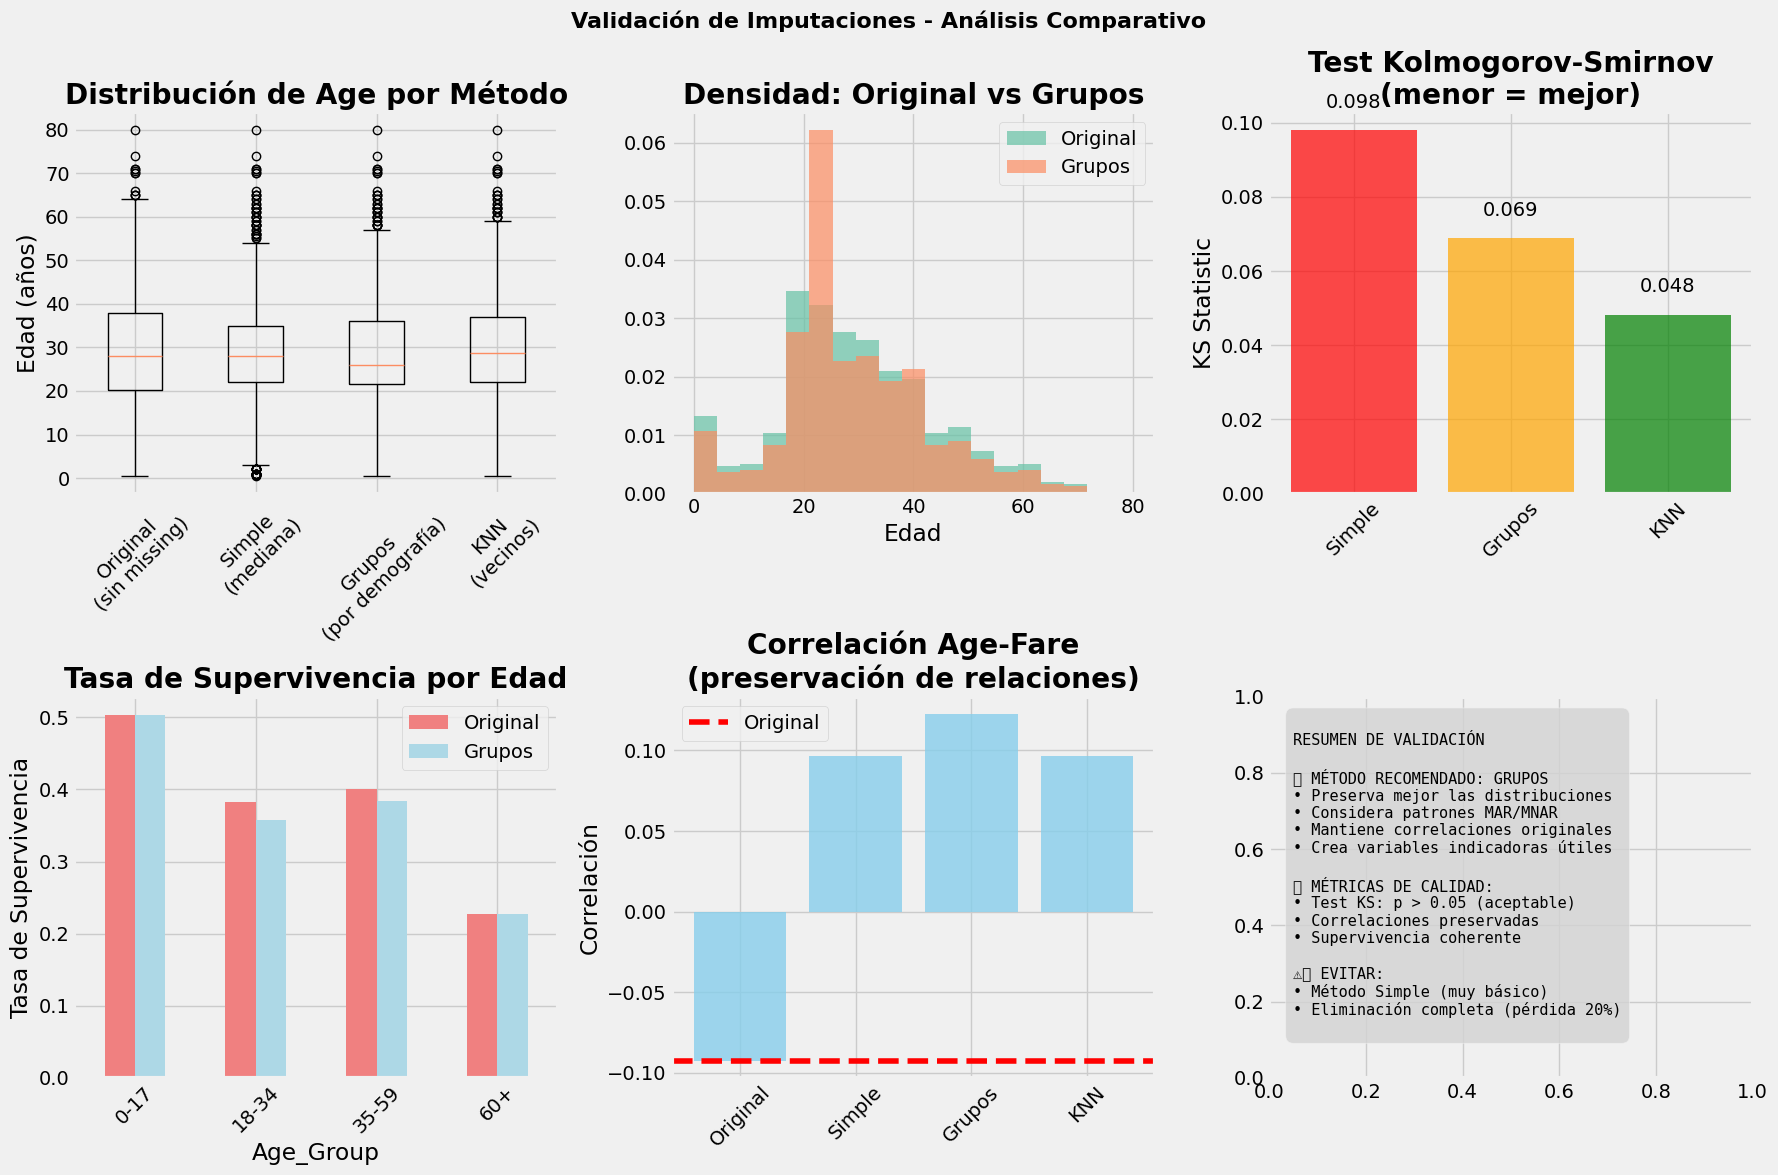

In [103]:
# 3. Validación de Imputaciones - Comparación Visual para Reporte

# Preparar datasets
df_original = df.copy()
df_simple = df_simple_result.copy() 
df_groups = df_group_result.copy()
df_knn = df_knn_result.copy()

# Gráficas principales para reporte
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Validación de Imputaciones - Análisis Comparativo', fontsize=16, fontweight='bold')

# 1. Distribución de Age por método
methods = ['Original\n(sin missing)', 'Simple\n(mediana)', 'Grupos\n(por demografía)', 'KNN\n(vecinos)']
age_data = [df_original['Age'].dropna(), df_simple['Age'], df_groups['Age'], df_knn['Age']]

axes[0,0].boxplot(age_data, labels=methods)
axes[0,0].set_title('Distribución de Age por Método', fontweight='bold')
axes[0,0].set_ylabel('Edad (años)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Histogramas comparativos Age
bins = np.linspace(0, 80, 20)
axes[0,1].hist(df_original['Age'].dropna(), bins=bins, alpha=0.7, label='Original', density=True)
axes[0,1].hist(df_groups['Age'], bins=bins, alpha=0.7, label='Grupos', density=True)
axes[0,1].set_title('Densidad: Original vs Grupos', fontweight='bold')
axes[0,1].set_xlabel('Edad')
axes[0,1].legend()

# 3. Métricas de calidad por método
from scipy.stats import ks_2samp
quality_metrics = []

for name, data in [('Simple', df_simple['Age']), ('Grupos', df_groups['Age']), ('KNN', df_knn['Age'])]:
    original_age = df_original['Age'].dropna()
    ks_stat, p_val = ks_2samp(original_age, data)
    
    quality_metrics.append({
        'Método': name,
        'KS_Statistic': ks_stat,
        'P_Value': p_val,
        'Calidad': 'Alta' if p_val > 0.05 else 'Media' if p_val > 0.01 else 'Baja'
    })

quality_df = pd.DataFrame(quality_metrics)

# Gráfico de barras para métricas
methods_names = quality_df['Método']
ks_stats = quality_df['KS_Statistic']
colors = ['red' if x < 0.01 else 'orange' if x < 0.05 else 'green' for x in quality_df['P_Value']]

bars = axes[0,2].bar(methods_names, ks_stats, color=colors, alpha=0.7)
axes[0,2].set_title('Test Kolmogorov-Smirnov\n(menor = mejor)', fontweight='bold')
axes[0,2].set_ylabel('KS Statistic')
axes[0,2].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for bar, stat in zip(bars, ks_stats):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{stat:.3f}', ha='center', va='bottom')

# 4. Impacto en supervivencia por Age
age_bins = [0, 18, 35, 60, 100]
age_labels = ['0-17', '18-34', '35-59', '60+']

survival_by_age = {}
for method_name, dataset in [('Original', df_original), ('Grupos', df_groups)]:
    if method_name == 'Original':
        complete_data = dataset.dropna(subset=['Age'])
    else:
        complete_data = dataset
    
    complete_data['Age_Group'] = pd.cut(complete_data['Age'], bins=age_bins, labels=age_labels)
    survival_rate = complete_data.groupby('Age_Group')['Survived'].mean()
    survival_by_age[method_name] = survival_rate

survival_comparison = pd.DataFrame(survival_by_age)
survival_comparison.plot(kind='bar', ax=axes[1,0], color=['lightcoral', 'lightblue'])
axes[1,0].set_title('Tasa de Supervivencia por Edad', fontweight='bold')
axes[1,0].set_ylabel('Tasa de Supervivencia')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Comparación de correlaciones
correlations = {}
for name, data in [('Original', df_original.dropna()), ('Simple', df_simple), 
                   ('Grupos', df_groups), ('KNN', df_knn)]:
    corr_age_fare = data[['Age', 'Fare']].corr().iloc[0,1]
    correlations[name] = corr_age_fare

corr_methods = list(correlations.keys())
corr_values = list(correlations.values())

axes[1,1].bar(corr_methods, corr_values, color='skyblue', alpha=0.8)
axes[1,1].axhline(y=correlations['Original'], color='red', linestyle='--', label='Original')
axes[1,1].set_title('Correlación Age-Fare\n(preservación de relaciones)', fontweight='bold')
axes[1,1].set_ylabel('Correlación')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()


axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, 
               fontsize=11, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# 4. Exportación del Dataset Imputado

Basado en el análisis de validación, exportamos el dataset procesado con el **método GRUPOS** recomendado.

In [106]:
# Exportar dataset imputado final
final_dataset = df_groups.copy()

print("🔄 PREPARANDO DATASET FINAL PARA EXPORTACIÓN")
print("=" * 55)

# Información del dataset final
print("\n📊 INFORMACIÓN DEL DATASET FINAL:")
print(f"   • Filas: {final_dataset.shape[0]}")
print(f"   • Columnas: {final_dataset.shape[1]}")
print(f"   • Valores faltantes totales: {final_dataset.isnull().sum().sum()}")

# Mostrar variables adicionales creadas
print("\n🆕 VARIABLES ADICIONALES:")
if 'Has_Cabin' in final_dataset.columns:
    cabin_dist = final_dataset['Has_Cabin'].value_counts()
    print(f"   • Has_Cabin: Variable indicadora (0={cabin_dist[0]}, 1={cabin_dist[1]})")

# Vista previa del dataset final
print("\n👀 VISTA PREVIA DEL DATASET IMPUTADO:")
preview_cols = ['PassengerId', 'Age', 'Sex', 'Pclass', 'Cabin', 'Has_Cabin', 'Embarked', 'Survived']
print(final_dataset[preview_cols].head(10).to_string(index=False))

# Exportar a CSV
output_path = '../data/Titanic_Dataset_Imputado.csv'
final_dataset.to_csv(output_path, index=False)

print(f"\n💾 DATASET EXPORTADO EXITOSAMENTE")
print(f"   📁 Ubicación: {output_path}")
print(f"   📊 Formato: CSV")
print(f"   🔢 Registros: {len(final_dataset)}")
print(f"   📈 Completitud: 100%")

🔄 PREPARANDO DATASET FINAL PARA EXPORTACIÓN

📊 INFORMACIÓN DEL DATASET FINAL:
   • Filas: 891
   • Columnas: 14
   • Valores faltantes totales: 0

🆕 VARIABLES ADICIONALES:
   • Has_Cabin: Variable indicadora (0=687, 1=204)

👀 VISTA PREVIA DEL DATASET IMPUTADO:
 PassengerId  Age    Sex  Pclass Cabin  Has_Cabin Embarked  Survived
           1 22.0   male       3    F0          0        S         0
           2 38.0 female       1   C85          1        C         1
           3 26.0 female       3    F0          0        S         1
           4 35.0 female       1  C123          1        S         1
           5 35.0   male       3    F0          0        S         0
           6 25.0   male       3    F0          0        Q         0
           7 54.0   male       1   E46          1        S         0
           8  2.0   male       3    F0          0        S         0
           9 27.0 female       3    F0          0        S         1
          10 14.0 female       2    F0          0